## Homework 4: Accumulation Opportunity In Electronic Market
### FINM 33150 (Winter 2025) - Quantitative Trading Strategies
#### NAME: Arturo Charleston
#### Student ID: 12449584

### Introduction

- In this notebook I analyze the feasibility of accumulating large positions in cryptocurrency markets (BTC and ETH) during 2022 and 2023 using a Volume Weighted Average Price participation algorithm.

- To analyze it, I use high-frequency nanoseconds data from BTC and ETH, which I clean and prepare to perform the accumulation algorithm.

- I construct the algorithm based on some main parameters.
1. Target Quantity (q) which is our desired quantity and it is a small fraction of certain quantile of the volume at a determined time duration (between 5-15 seconds)
2. Target Participation (p) which is the participation that we would like to get on our determined duration.
3. Minimum Size Threshold (g) is the minimum amount we would like to trade. If the requested order is less than this minimum threshold, then we do not provide liquidity to this trade. 
4. Quoting Participation rate (k(p)) is the actual participation rate. It is calculated based on the target participation, and it must not exceed 0.05. It must be larger than the target participation p because some trades are unavailable for participation

- Then, I construct the algorithm for one dataset, which latter I divide into different windows to check changes inside a window. I vary this window from 15 seconds to 60 seconds in 15 seconds increments. 

- Then I test how my algorithm varies as I change the parameters. I overlap the histograms of the main variables when changing the parameters to find the interaction between parameters and some variables of interest. 


In [40]:
# PACKAGES
import os
import warnings
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Global Options
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.5f}'.format

# Set directory
home_directory = "/Users/charleston/Downloads/git_repositories/finm-qts-2025"
os.chdir(home_directory)


### Functions

In [41]:
def convert_units(df):
    if 'PriceMillionths' in df.columns:
        df['PriceMillionths'] = df['PriceMillionths'] / 1_000_000  # Price in understandable format
    if 'SizeBillionths' in df.columns:
        df['SizeBillionths'] = df['SizeBillionths'] / 1_000_000_000  # Size in understandable format
    if 'timestamp_utc_nanoseconds' in df.columns:
        # Convert to datetime; note that later subtractions will yield timedelta objects.
        df['timestamp_utc_nanoseconds_dt'] = pd.to_datetime(df['timestamp_utc_nanoseconds'], unit='ns')
    # We only care about the sign of Side, make it a boolean
    if 'Side' in df.columns:
        df['Side'] = df['Side'].apply(lambda x: 1 if x > 0 else -1)
    return df

def filter_contiguous_chunks(df, seconds = 60*5):
    # Only keep segments in which no gap of 60 seconds (1 minute) occurs.
    df = df.sort_values('timestamp_utc_nanoseconds_dt')
    # Compute time difference (in seconds) between consecutive trades:
    df['dt_diff'] = df['timestamp_utc_nanoseconds_dt'].diff().dt.total_seconds().fillna(0)
    # Each time the gap exceeds seconds, mark a new segment.
    df['segment'] = (df['dt_diff'] > seconds).cumsum()
    # For each segment, check its maximum gap; keep only those segments where the maximum gap is less than 60.
    valid_segments = df.groupby('segment')['dt_diff'].max()
    valid_segments = valid_segments[valid_segments < seconds].index
    df = df[df['segment'].isin(valid_segments)].copy()
    # Remove helper columns
    df.drop(['dt_diff', 'segment'], axis=1, inplace=True)
    
    return df

def get_time_range(df):
    start_time = df['timestamp_utc_nanoseconds_dt'].min()
    end_time = df['timestamp_utc_nanoseconds_dt'].max()
    time_diff = end_time - start_time
    return start_time, end_time, time_diff

def calculate_buy_sell_percentage(df):
    total_trades = len(df)
    buy_trades = len(df[df['Side'] == 1])
    sell_trades = len(df[df['Side'] == -1])
    
    buy_percentage = (buy_trades / total_trades) * 100
    sell_percentage = (sell_trades / total_trades) * 100
    
    return buy_percentage, sell_percentage

def calculate_vwap(df):
    # Calculate VWAP
    df['vwap'] = (df['PriceMillionths'] * df['SizeBillionths']).cumsum() / df['SizeBillionths'].cumsum()
    return df

def plot_price_vwap(df1, df2, title1, title2):
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(df1['timestamp_utc_nanoseconds_dt'], df1['PriceMillionths'], label='Price', color='blue')
    plt.plot(df1['timestamp_utc_nanoseconds_dt'], df1['vwap'], label='VWAP', linestyle='--', color='orange')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title(title1)
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(df2['timestamp_utc_nanoseconds_dt'], df2['PriceMillionths'], label='Price', color='blue')
    plt.plot(df2['timestamp_utc_nanoseconds_dt'], df2['vwap'], label='VWAP', linestyle='--', color='orange')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title(title2)
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

### Algorithm Functions


In [42]:
def compute_target_quantity(
    df: pd.DataFrame,
    freq: str = '5Min',
    percentile: float | list = 0.65,
    fraction: float | list = 0.02
) -> list | float:
    """
    Compute target quantity Q by forming a cumulative sum of volumes
    and then taking the difference with a delayed version (by freq).
    
    Parameters:
    - percentile: Single value or list of percentile values between 0 and 1
    - fraction: Single value or list of fraction values between 0 and 1
    
    Returns:
    - If both inputs are single values: returns a single Q value
    - If either is a list: returns a list of Q values (cartesian product if both are lists)
    """
    if 'timestamp_utc_nanoseconds_dt' not in df.columns:
        df['timestamp_utc_nanoseconds_dt'] = pd.to_datetime(df['timestamp_utc_nanoseconds'], unit='ns')
    df = df.sort_values('timestamp_utc_nanoseconds_dt')
    df = df.set_index('timestamp_utc_nanoseconds_dt')
    
    # Cumulative sum of volumes (using already converted SizeBillionths)
    cum_vol = df['SizeBillionths'].cumsum()
    
    # Shift by the frequency (e.g., 5 minutes) and compute the difference
    cum_vol_shifted = cum_vol.shift(freq=freq)
    vol_diff = cum_vol - cum_vol_shifted
    vol_diff = vol_diff.dropna()
    
    # Convert inputs to lists if they're not already
    percentiles = [percentile] if isinstance(percentile, (int, float)) else percentile
    fractions = [fraction] if isinstance(fraction, (int, float)) else fraction
    
    # Compute Q values for all combinations
    Q_values = []
    for p in percentiles:
        vol_percentile = vol_diff.quantile(p)
        for f in fractions:
            Q_values.append(f * vol_percentile)
            
    # Return single value if both inputs were single values
    if len(Q_values) == 1:
        return Q_values[0]
    
    return Q_values

def compute_minimum_threshold(
    df: pd.DataFrame,
    percentile: float | list = 0.05
) -> list | float:
    """
    Compute the trade-size threshold g as the given percentile
    of all trade sizes in the dataset.
    
    Parameters:
    - percentile: Single value or list of percentile values between 0 and 1
    
    Returns:
    - If input is a single value: returns a single g value
    - If input is a list: returns a list of g values
    """
    percentiles = [percentile] if isinstance(percentile, (int, float)) else percentile
    
    g_values = [df['SizeBillionths'].quantile(p) for p in percentiles]
    
    if len(g_values) == 1:
        return g_values[0]
    
    return g_values

    
def filter_side(df: pd.DataFrame, Q: float) -> pd.DataFrame:
    """
    If Q>0 (we are buyers), filter trades where Side < 0 (aggressor is seller).
    If Q<0 (we are sellers), filter trades where Side > 0 (aggressor is buyer).
    """
    if Q > 0:
        return df[df['Side'] < 0].copy()
    else:
        return df[df['Side'] > 0].copy()
    
def compute_vwap_for_interval(trades_df, start_ns, end_ns, PRICE_CONVERSION=1, VOLUME_CONVERSION=1):
    """
    Compute the VWAP of trades in [start_ns, end_ns).
    Returns the VWAP (weighted average price) or np.nan if no trades in interval.
    
    :param trades_df: DataFrame with trades data.
                       Must contain 'timestamp_utc_nanoseconds', 'PriceMillionths', and 'SizeBillionths'.
    :param start_ns:  Start time in nanoseconds.
    :param end_ns:    End time in nanoseconds.
    :param PRICE_CONVERSION: Factor to convert price units (default 1).
    :param VOLUME_CONVERSION: Factor to convert volume units (default 1).
    :return: VWAP (float) or np.nan.
    """
    mask = (trades_df['timestamp_utc_nanoseconds'] >= start_ns) & \
           (trades_df['timestamp_utc_nanoseconds'] < end_ns)
    sub = trades_df.loc[mask]
    if sub.empty:
        return np.nan
    # Notional: (price * conversion) * (size * conversion)
    notional = (sub['PriceMillionths'] * PRICE_CONVERSION) * (sub['SizeBillionths'] * VOLUME_CONVERSION)
    total_qty = sub['SizeBillionths'] * VOLUME_CONVERSION
    if total_qty.sum() == 0:
        return np.nan
    vwap = notional.sum() / total_qty.sum()
    return vwap

def vwap_participation_vectorized(
    df: pd.DataFrame,
    Q: float,
    p: float,
    g: float,
    pair: str = 'BTC-USD',
    print_summary: bool = False,
    pause_seconds: float = 3.0  # pause duration in seconds
) -> pd.DataFrame:
    """
    Vectorized VWAP simulation that:
      - Filters trades by side.
      - Computes potential fill = (size - g)*p.
      - Fills trades in one or more "sweeps" until target Q is met.
      - After a sweep, pauses for pause_seconds (by zeroing out trades during that interval).
      - Returns a DataFrame with per‐trade fill_qty, cumulative fill, cost, fees, etc.
    """
    # Fee rate logic
    if '-USD' in pair.upper():
        fee_rate = 0.005  # 0.5% fee for crypto-fiat
    else:
        fee_rate = 0.001  # 0.1% fee for crypto-crypto

    # Adjust k for slippage or missed fills, but ensure it doesn't exceed 5%
    k = min(p * adjustment_k, 0.05)
    if k > 0.05:
        raise ValueError("Participation rate k must not exceed 0.05 (5%).")
    
    # (1) Filter trades by side
    eligible = filter_side(df, Q)
    eligible['size'] = eligible['SizeBillionths']
    eligible['price'] = eligible['PriceMillionths']
    
    # (2) Convert timestamps and sort
    eligible['datetime'] = pd.to_datetime(eligible['timestamp_utc_nanoseconds'], unit='ns')
    eligible.sort_values('datetime', inplace=True)
    
    # (3) Compute potential fill: only count volume above threshold g
    eligible['eligible_size'] = np.where(eligible['size'] > g, eligible['size'] - g, 0.0)
    potential_fill = eligible['eligible_size'].to_numpy() * k
    
    # (4) Prepare timestamps array and pause constant
    T = eligible['timestamp_utc_nanoseconds'].to_numpy()  # in nanoseconds
    P_ns = pause_seconds * 1e9  # pause duration in nanoseconds
    
    n = len(potential_fill)
    final_fill = np.zeros(n)
    active_mask = np.ones(n, dtype=bool)
    Q_remaining = abs(Q)
    indices = np.arange(n)
    
    # ITERATIVELY SIMULATE "SWEEPS" WITH PAUSE
    while Q_remaining > 1e-12:
        active_indices = indices[active_mask]
        if len(active_indices) == 0:
            break
        active_potential = potential_fill[active_indices]
        csum = np.cumsum(active_potential)
        if not np.any(csum >= Q_remaining):
            final_fill[active_indices] += active_potential
            Q_remaining -= csum[-1]
            break
        else:
            idx_in_active = np.argmax(csum >= Q_remaining)
            if idx_in_active > 0:
                final_fill[active_indices[:idx_in_active]] += active_potential[:idx_in_active]
            prev_csum = csum[idx_in_active - 1] if idx_in_active > 0 else 0.0
            fill_amount = Q_remaining - prev_csum
            final_fill[active_indices[idx_in_active]] += fill_amount
            Q_remaining = 0.0
            sweep_end_time = T[active_indices[idx_in_active]]
            active_mask = active_mask & (T >= (sweep_end_time + P_ns))
            break  # Stop after one sweep
    
    # (5) Apply sign to final fill and store in DataFrame.
    signed_fill = final_fill * (1.0 if Q > 0 else -1.0)
    eligible['fill_qty'] = signed_fill
    
    # (6) Label each trade as 'full', 'partial', or 'none'
    partial_mask = (final_fill < potential_fill) & (final_fill > 0)
    fill_type = np.where(final_fill > 0,
                         np.where(partial_mask, "partial", "full"),
                         "none")
    eligible['fill_type'] = fill_type
    
    # (7) Compute cumulative fill, Q remaining, cost, and fees.
    eligible['cumulative_fill'] = np.cumsum(signed_fill)
    csum_final = eligible['cumulative_fill'].to_numpy()
    csum_shifted = np.roll(csum_final, 1)
    csum_shifted[0] = 0.0
    eligible['Q_remaining_before'] = Q - csum_shifted
    eligible['Q_remaining_after'] = Q - csum_final
    
    eligible['cost_usd'] = eligible['fill_qty'] * eligible['price']
    eligible['fee_usd'] = np.abs(eligible['cost_usd']) * fee_rate
    
    # (8) Compute fill duration and average fill price.
    fill_rows = eligible[eligible['fill_qty'] != 0]
    if len(fill_rows) > 0:
        first_fill_time = fill_rows.iloc[0]['datetime']
        last_fill_time = fill_rows.iloc[-1]['datetime']
        fill_duration = (last_fill_time - first_fill_time).total_seconds()
    else:
        fill_duration = 0
    eligible['fill_duration_seconds'] = fill_duration
    eligible['fill_duration_min'] = fill_duration / 60
    
    total_filled = eligible['fill_qty'].sum()
    total_cost = eligible['cost_usd'].sum()
    if total_filled != 0:
        avg_fill_price = total_cost / total_filled
    else:
        avg_fill_price = np.nan
    eligible['avg_fill_price'] = avg_fill_price
    
    # Calculate fraction filled (target Q is assumed to be abs(Q))
    fraction_filled = abs(total_filled) / abs(Q) if abs(Q) > 1e-12 else np.nan
    eligible['fraction_filled'] = fraction_filled
    
    # Order_filled: True if nearly full fill (e.g., >= 99.99%)
    eligible['order_filled'] = fraction_filled >= 0.9999
    
    # Order_in_Time: acceptable fill duration between 60 seconds and 15 minutes
    acceptable_min = 60         # seconds
    acceptable_max = 15 * 60    # seconds
    eligible['order_in_time'] = (fill_duration >= acceptable_min) and (fill_duration <= acceptable_max)
    
    # Notional per time: total notional (cost) divided by fill duration (in seconds)
    notional_per_time = total_cost / fill_duration if fill_duration > 0 else np.nan
    eligible['notional_per_time'] = notional_per_time
    
    # Trading cost ratio: total fees / total notional
    trading_cost_ratio = eligible['fee_usd'].sum() / total_cost if total_cost > 0 else np.nan
    eligible['trading_cost_ratio'] = trading_cost_ratio
    
    # Compute actual participation rate (p_real) ***
    total_traded_in_window = eligible['size'].sum()  # total trade size in the eligible window
    p_real = abs(total_filled) / total_traded_in_window if total_traded_in_window > 0 else 0
    eligible['p_real'] = p_real
    
    # Save the target participation rate and effective k as columns.
    eligible['target_p'] = p
    eligible['k'] = k  # effective participation rate used in the simulation
    
    # Market VWAP and relative performance (to be filled in by the window function)
    eligible['market_vwap'] = np.nan  
    eligible['rel_to_arrival'] = np.nan
    eligible['rel_to_market'] = np.nan
    
    if print_summary:
        print("----------- VWAP Participation Results -----------")
        print(f"Pair: {pair}")
        print(f"Fee rate = {fee_rate:.2%}")
        print(f"Target Q = {Q:.4f}   p = {p:.2%}, threshold g = {g:.4e}")
        print(f"Total filled = {total_filled:.4f}")
        if not np.isnan(avg_fill_price):
            print(f"VWAP Price (USD per BTC) = {avg_fill_price:.4f}")
            print(f"Total Cost (USD) = {total_cost:.4f}")
        print(f"Total fees (USD) = {eligible['fee_usd'].sum():.4f}")
        print(f"Filled trades count = {(eligible['fill_qty'] != 0).sum()}")
        print(f"Time to fill (minutes) = {fill_duration/60:.2f}")
        print(f"Actual participation (p_real) = {p_real:.2%}")
        print("------------------------------------------------\n")
    
    return eligible


##########################################
# MODIFIED SIMULATE VWAP IN TIME WINDOWS FUNCTION
##########################################
def simulate_vwap_in_time_windows(
    df: pd.DataFrame,
    Q: float,
    p: float,
    g: float,
    window: str = '15Min',
    pair: str = 'BTC-USD',
    pause_seconds: float = 3.0,
    PRICE_CONVERSION: float = 1,
    VOLUME_CONVERSION: float = 1
) -> pd.DataFrame:
    """
    Break the data into time windows (e.g., 15Min). For each window:
      - Determine the arrival price (the first trade's price in that window).
      - Compute the market VWAP for the window.
      - Run vwap_participation_vectorized with Q, p, g on that subset.
      - Attach 'arrival_price' and 'market_vwap' to all rows.
      - Compute extra metrics (order_filled, order_in_time, relative performance,
        notional per time, trading cost ratio) and attach as columns.
      - Return a single DataFrame with all windows concatenated.
    NOTE: Each window is simulated independently.
    """
    # Ensure we have a datetime column
    if 'datetime' not in df.columns:
        df = df.copy()
        df['datetime'] = pd.to_datetime(df['timestamp_utc_nanoseconds'], unit='ns')
    df = df.set_index('datetime').sort_index()

    results_list = []
    window_ns = pd.Timedelta(window).value  # window length in ns

    for win_start_time, group_df in df.groupby(pd.Grouper(freq=window)):
        if len(group_df) == 0:
            continue
        group_df = group_df.reset_index(drop=False)
        group_df.sort_values('datetime', inplace=True)
        
        # Arrival price: first trade's price in window (using PriceMillionths)
        arrival_price = group_df.iloc[0]['PriceMillionths']
        
        # Compute market VWAP for this window using all trades in group_df.
        start_ns = group_df.iloc[0]['timestamp_utc_nanoseconds']
        end_ns = start_ns + window_ns
        market_vwap = compute_vwap_for_interval(
            trades_df=group_df,
            start_ns=start_ns,
            end_ns=end_ns,
            PRICE_CONVERSION=PRICE_CONVERSION,
            VOLUME_CONVERSION=VOLUME_CONVERSION
        )
        
        # Run the simulation on this window.
        window_result = vwap_participation_vectorized(
            df=group_df,
            Q=Q,
            p=p,
            g=g,
            pair=pair,
            print_summary=False,
            pause_seconds=pause_seconds
        )
        
        # Add arrival price and market_vwap to all rows.
        window_result['arrival_price'] = arrival_price
        window_result['market_vwap'] = market_vwap
        window_result['window_start_time'] = win_start_time
        
        # Now compute the extra relative performance metrics on this window.
        # Use the (broadcast) avg_fill_price from the simulation.
        avg_fill_price = window_result['avg_fill_price'].iloc[0]
        rel_to_arrival = (avg_fill_price / arrival_price - 1) if (arrival_price and arrival_price != 0 and not np.isnan(avg_fill_price)) else np.nan
        rel_to_market = (avg_fill_price / market_vwap - 1) if (market_vwap and market_vwap != 0 and not np.isnan(avg_fill_price)) else np.nan
        
        window_result['rel_to_arrival'] = rel_to_arrival
        window_result['rel_to_market'] = rel_to_market
        
        results_list.append(window_result)
    
    if len(results_list) > 0:
        all_results_df = pd.concat(results_list, ignore_index=True)
    else:
        all_results_df = pd.DataFrame()
    
    return all_results_df



### Read the data

- We are reading the crypto data for years 2022, 2023, and 2024. 
- Given that the order book dataset is only used to compute the arrival price, we won't use it and we will set the arrival price to be the price of the first trade after receiving the order. 

In [43]:
search_path = os.path.join(home_directory, 'data', 'Crypto')
list_of_files = []

for year in [2022, 2023]:
    folder = os.path.join(search_path, str(year))
    for filename in os.listdir(folder):
        if "narrow" in filename.lower():
            match = re.search(r"(trades)_narrow_([^_]+)_(\d{4})", filename)
            if match:
                data_type = match.group(1) 
                symbols = match.group(2).replace('-', '_')
                df_name = f"{symbols}_{data_type}_{year}"
                filepath = os.path.join(folder, filename)
                #print(f"Reading {filepath} into {df_name}")
                list_of_files.append(df_name)
                if filename.endswith(".gz"):
                    globals()[df_name] = pd.read_csv(filepath, compression='gzip', sep='\t')
                else:
                    globals()[df_name] = pd.read_csv(filepath, sep='\t')
                print(f"Reading {df_name}")


Reading ETH_USD_trades_2022
Reading ETH_BTC_trades_2022
Reading BTC_USD_trades_2022
Reading ETH_USD_trades_2023
Reading ETH_BTC_trades_2023
Reading BTC_USD_trades_2023


### Data Cleaning

- To clean the data I convert the units to a human readable format. I convert the time into a timestamp with date, hour and nanoseconds. I convert the price in millionths to dollars, and the size in billionths to share of the respective cryptocurrency. 
- The data contains gaps between time that will affect the accumulation algorithm. Then I make the decision of not considering those nanoseconds without a trade happening in a 5 second window. 
- I construct the Volume Weighted Average Price, and plot it with the Price in USD for BTC and ETH in 2022-2023 and provide a few descriptive statistics of the data before starting the accumulation algorithm

In [44]:
# Apply the functions to all data frames
for df_name in list_of_files:
    df = globals()[df_name]
    df = convert_units(df)
    df = filter_contiguous_chunks(df)
    globals()[df_name] = df


In [45]:
time_ranges = {}
for df_name in list_of_files:
    df = globals()[df_name]
    time_ranges[df_name] = get_time_range(df)

for df_name, (start_time, end_time, time_diff) in time_ranges.items():
    print(f"{df_name}: {start_time} to {end_time} (Duration: {time_diff})")

ETH_USD_trades_2022: 2022-01-29 21:02:52.762420 to 2022-02-05 01:29:55.456813 (Duration: 6 days 04:27:02.694393)
ETH_BTC_trades_2022: 2022-01-29 21:02:56.287757 to 2022-02-05 01:29:47.860828 (Duration: 6 days 04:26:51.573071)
BTC_USD_trades_2022: 2022-01-29 21:02:49.574850 to 2022-02-05 01:29:55.223562 (Duration: 6 days 04:27:05.648712)
ETH_USD_trades_2023: 2023-01-24 00:47:51.071902 to 2023-01-24 01:00:06.444122 (Duration: 0 days 00:12:15.372220)
ETH_BTC_trades_2023: 2023-01-24 00:49:06.020758 to 2023-01-24 01:04:20.932168 (Duration: 0 days 00:15:14.911410)
BTC_USD_trades_2023: 2023-01-24 00:47:47.874527 to 2023-01-24 02:59:16.378575 (Duration: 0 days 02:11:28.504048)


In [46]:
buy_sell_percentages = {}

for df_name in list_of_files:
    df = globals()[df_name]
    buy_percentage, sell_percentage = calculate_buy_sell_percentage(df)
    buy_sell_percentages[df_name] = {
        'buy_percentage': buy_percentage,
        'sell_percentage': sell_percentage
    }

for df_name, percentages in buy_sell_percentages.items():
    print(f"{df_name}: Buy = {percentages['buy_percentage']:.2f}%, Sell = {percentages['sell_percentage']:.2f}%")

ETH_USD_trades_2022: Buy = 61.99%, Sell = 38.01%
ETH_BTC_trades_2022: Buy = 57.25%, Sell = 42.75%
BTC_USD_trades_2022: Buy = 61.95%, Sell = 38.05%
ETH_USD_trades_2023: Buy = 50.07%, Sell = 49.93%
ETH_BTC_trades_2023: Buy = 64.71%, Sell = 35.29%
BTC_USD_trades_2023: Buy = 62.02%, Sell = 37.98%


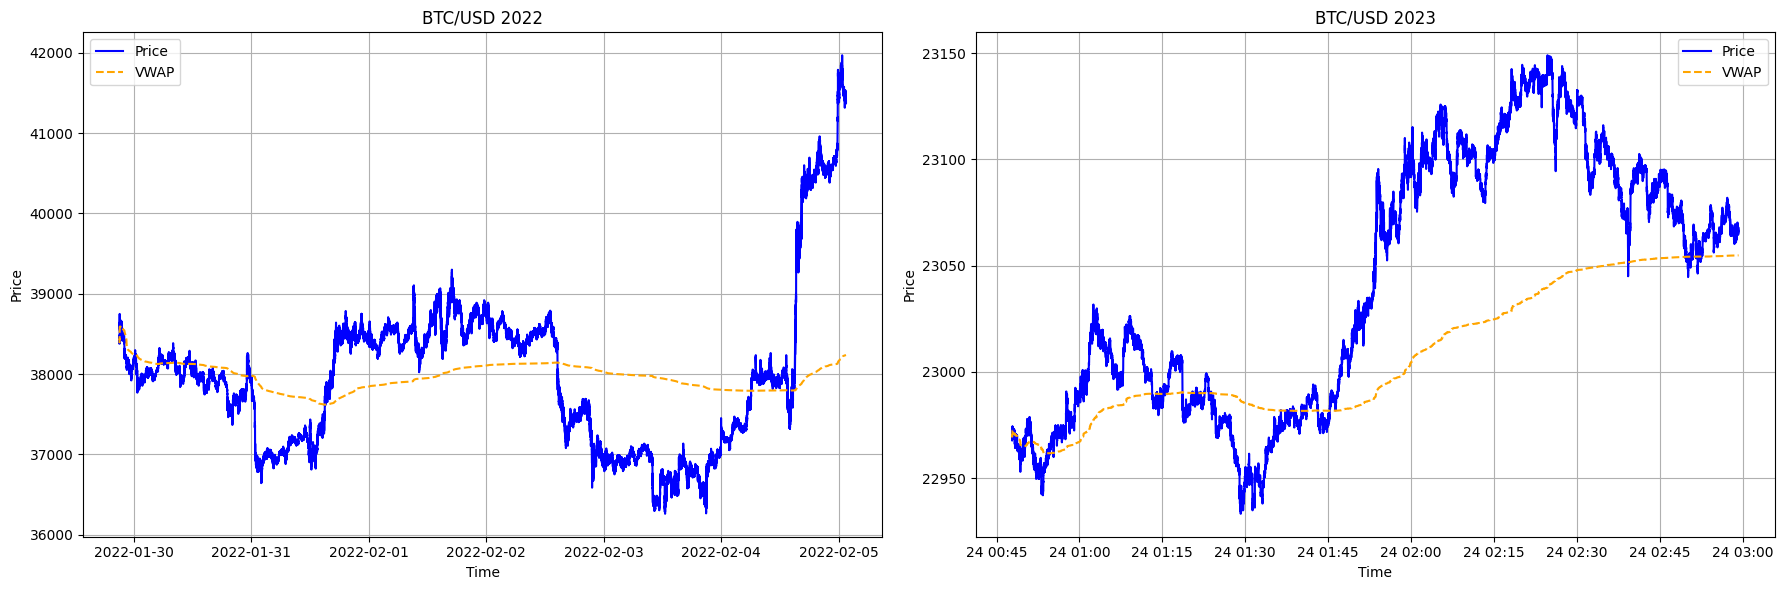

In [47]:
# Rename dataframes
renamed_files = {
    'ETH_USD_trades_2022': 'ETH/USD 2022',
    'ETH_USD_trades_2023': 'ETH/USD 2023',
    'BTC_USD_trades_2022': 'BTC/USD 2022',
    'BTC_USD_trades_2023': 'BTC/USD 2023',
    'ETH_BTC_trades_2022': 'ETH/BTC 2022',
    'ETH_BTC_trades_2023': 'ETH/BTC 2023'
}

# Calculate VWAP for each dataframe
for df_name, new_name in renamed_files.items():
    df = globals()[df_name]
    df = calculate_vwap(df)
    globals()[new_name] = df

# Plot BTC/USD 2022 and 2023 side by side
plot_price_vwap(globals()['BTC/USD 2022'], globals()['BTC/USD 2023'], 'BTC/USD 2022', 'BTC/USD 2023')



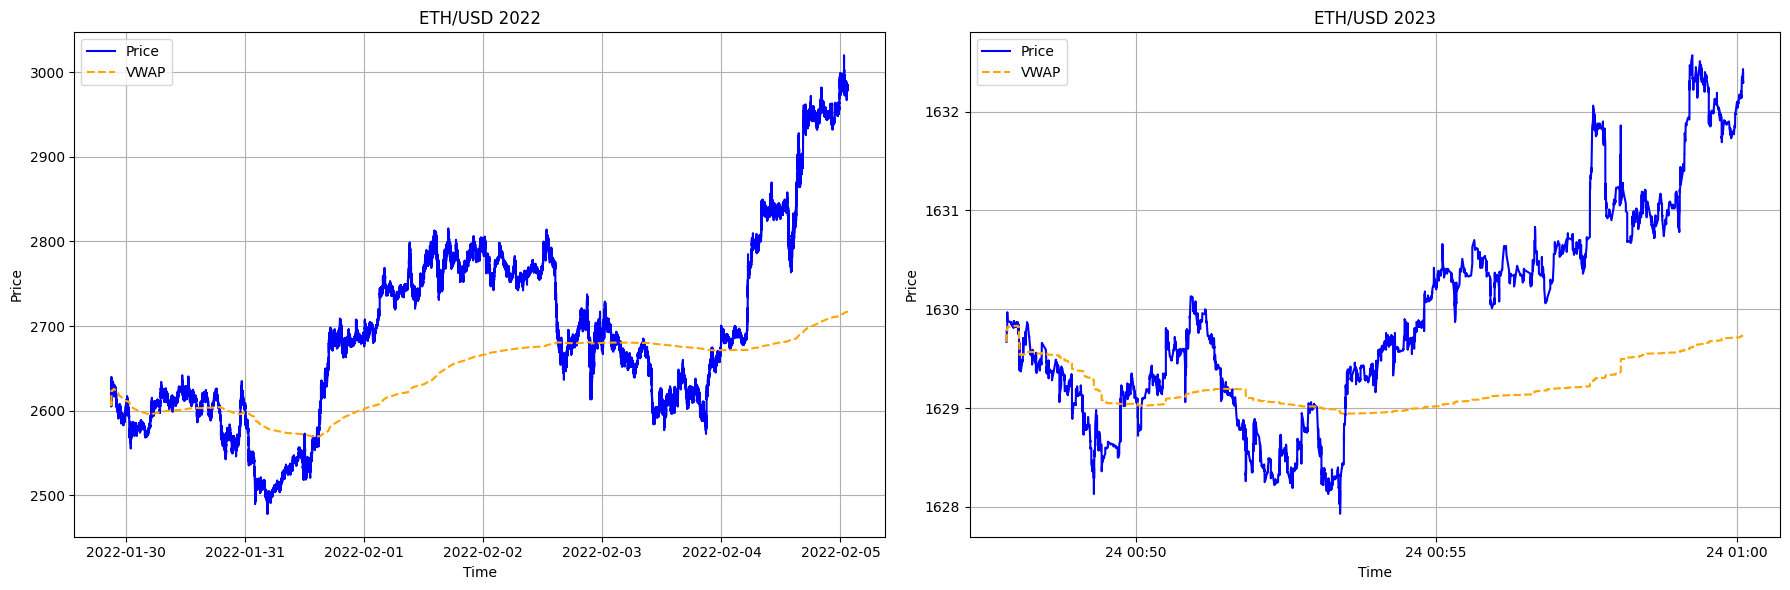

In [48]:
# ETH/USD 2022 and 2023
plot_price_vwap(globals()['ETH/USD 2022'], globals()['ETH/USD 2023'], 'ETH/USD 2022', 'ETH/USD 2023')

We can see that the VWAP calculation smooths price fluctuations overtime. We can note that the price of both cryptocurrencies is highly volatile, with significant price changes in a few days.

### Volume Weighted Adjusted Price Accumulation algorithm

- I implement a passive VWAP to model the execution process based on the historical data. In addition, I include different parameters to model the real conditions, I vary these parameters to see how the main indicators change. 

- To determine the appropriate parameters, I create different functions to select them
1. The target quantity is chosen to be a small fraction (between 0.01 and 0.05) of a percentile of the volume. To do this, I form cumulative sum of volumes, of which then I take the difference with its 15 minutes delayed self. I allow my function to vary the percentiles, and fractions used to test for different combinations of the parameters as shown below. 
2. The minimum threshold is computed based a percentile of the volume. This number is used to filter small trades that are unlikely to be in queue position.

In addition, the algorithm consider other parameters to simulate real implementation conditions
1. I select a limited participation rate $p$ to ensure that the strategy remains passive. This parameter is arbitrarily selected and it is small 
2. The quoting participation rate is defined as $min(1.2p, 0.05)$, to be constrained to be <= 0.05
3. Pauses in execution. I select this to be 2 seconds, and it is used to prevent excessive accumulation when we exceed our target rate


In [49]:
# First parameter selection
adjustment_k = 1.2
Q = compute_target_quantity(
    BTC_USD_trades_2022,
    freq='5Min',
    percentile=0.35,
    fraction=0.05
)

g = compute_minimum_threshold(BTC_USD_trades_2022, percentile=0.08)

p = 0.02  # 2%
# Adjust k for slippage or missed fills, but ensure it doesn't exceed 5%
k = min(p * adjustment_k, 0.05)

print("Computed Q:", Q, "BTC")
print("Minimum threshold g:", g, "BTC")
print("Participation rate p:", p)
print("Adjusted participation rate k:", k)

Computed Q: 1.8561309055558377 BTC
Minimum threshold g: 7.727e-05 BTC
Participation rate p: 0.02
Adjusted participation rate k: 0.024


### Initial Simulation

To test my accumulation algorithm, I start with two initial simulations

- First I calculate the VWAP algorithm based on BTC_USD trades during 2022 in the whole data period and present a few statistics of the accumulation.

- Then, instead of using the whole data, I construct the accumulation algorithm based on 15 minutes windows. This allow me to identify different arrival prices, and compare the accumulation algorithm in different samples

- After confirming that my algorithm works as expected, I proceed in the next section varying some of the parameters to test how my algorithm work under different scenarios

- The initial simulation include some reasonable parameters as defined above. Those are based on homework instructions. 

In [50]:
results_df = vwap_participation_vectorized(
    df=BTC_USD_trades_2022,  # your DataFrame with the specified columns
    Q=Q,           # want to buy 10 BTC
    p=0.02,           # 2% participation rate
    g=g,      # min threshold in the same "SizeBillionths" scale
    pair='BTC-USD',    # fee logic
    print_summary=True,  # print summary
    pause_seconds=3.0  # pause duration
)

----------- VWAP Participation Results -----------
Pair: BTC-USD
Fee rate = 0.50%
Target Q = 1.8561   p = 2.00%, threshold g = 7.7270e-05
Total filled = 1.8561
VWAP Price (USD per BTC) = 38589.5959
Total Cost (USD) = 71627.3416
Total fees (USD) = 358.1367
Filled trades count = 2531
Time to fill (minutes) = 11.72
Actual participation (p_real) = 0.00%
------------------------------------------------



### Initial Simulation

1. The initial simulation was fully executed
2. It took 11.72 minutes to fill
3. The VWAP price was 38,589 USD

### Execution time and volume percentile

- To ensure correct execution, I test different percentiles to calculate the volume to decide our target quantity. 

- We can note that there is a clear positive relationship between the volume selected, and the time to fill 

- We can note that when we use a percentile lower than 0.8, our orders are filled before 15 minutes. So we can stick with a volume as long as it is smaller than the 80%. 

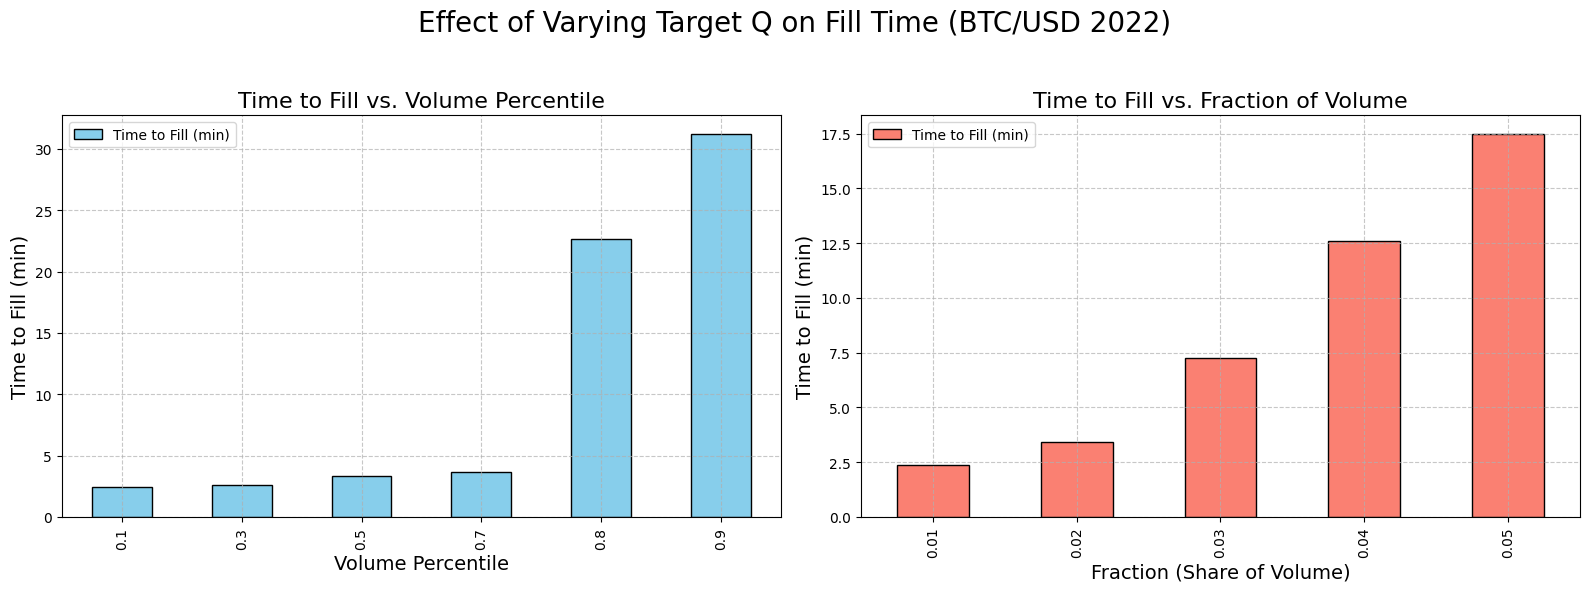

In [51]:
# Define a list of volume percentiles to try.
percentiles_to_try = [0.1, 0.3, 0.5, 0.7, 0.8, 0.9]
fixed_fraction = 0.02  # fixed share of the volume percentile

# List to store results as tuples: (volume_percentile, time_to_fill in minutes)
results_time_pct = []

for pct in percentiles_to_try:
    # Compute the target Q using your function.
    Q_val = compute_target_quantity(BTC_USD_trades_2022,
                                    freq='5Min',
                                    percentile=pct,
                                    fraction=fixed_fraction)
    # Run your simulation.
    sim_result = vwap_participation_vectorized(
        df=BTC_USD_trades_2022,
        Q=Q_val,
        p=p,
        g=g,
        pair='BTC-USD',
        print_summary=False,
        pause_seconds=3.0
    )
    # Extract the fill duration in minutes from the simulation.
    fill_time_min = sim_result['fill_duration_min'].iloc[0]
    results_time_pct.append((pct, fill_time_min))

# Convert the list to a DataFrame.
df_time_pct = pd.DataFrame(results_time_pct, columns=['Volume Percentile', 'Time to Fill (min)'])
df_time_pct.set_index('Volume Percentile', inplace=True)

# -------------------------------
# Part 2: Varying Fraction (with fixed volume percentile)
# -------------------------------

# Define a list of fraction values (share you take) to try.
fractions_to_try = [0.01, 0.02, 0.03, 0.04, 0.05]
fixed_percentile = 0.65  # fixed volume percentile

results_time_frac = []

for frac in fractions_to_try:
    Q_val = compute_target_quantity(BTC_USD_trades_2022,
                                    freq='5Min',
                                    percentile=fixed_percentile,
                                    fraction=frac)
    sim_result = vwap_participation_vectorized(
        df=BTC_USD_trades_2022,
        Q=Q_val,
        p=p,
        g=g,
        pair='BTC-USD',
        print_summary=False,
        pause_seconds=3.0
    )
    fill_time_min = sim_result['fill_duration_min'].iloc[0]
    results_time_frac.append((frac, fill_time_min))

df_time_frac = pd.DataFrame(results_time_frac, columns=['Fraction', 'Time to Fill (min)'])
df_time_frac.set_index('Fraction', inplace=True)

# -------------------------------
# Plotting the Two Bar Graphs Side by Side
# -------------------------------

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Time to Fill vs. Volume Percentile
df_time_pct.plot(kind='bar', ax=axs[0], color='skyblue', edgecolor='black')
axs[0].set_xlabel("Volume Percentile", fontsize=14)
axs[0].set_ylabel("Time to Fill (min)", fontsize=14)
axs[0].set_title("Time to Fill vs. Volume Percentile", fontsize=16)
axs[0].grid(True, linestyle='--', alpha=0.7)

# Plot 2: Time to Fill vs. Fraction (Share of Volume)
df_time_frac.plot(kind='bar', ax=axs[1], color='salmon', edgecolor='black')
axs[1].set_xlabel("Fraction (Share of Volume)", fontsize=14)
axs[1].set_ylabel("Time to Fill (min)", fontsize=14)
axs[1].set_title("Time to Fill vs. Fraction of Volume", fontsize=16)
axs[1].grid(True, linestyle='--', alpha=0.7)

plt.suptitle("Effect of Varying Target Q on Fill Time (BTC/USD 2022)", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()


In [52]:
all_results_df = simulate_vwap_in_time_windows(
    df=BTC_USD_trades_2022,  # your DataFrame with the specified columns
    Q=Q,           # want to buy 10 BTC
    p=0.02,           # 2% participation rate
    g=g,      # min threshold in the same "SizeBillionths" scale
    window='15Min',  # time window for each simulation
    pair='BTC-USD',    # fee logic
    pause_seconds=3.0  # pause duration
)

In [53]:
summary_by_window = (
    all_results_df
    .groupby('window_start_time')
    .agg({
       'fill_qty':'sum',
       'cost_usd':'sum',
       'fee_usd':'sum',
       'arrival_price':'first',  # The arrival price was constant in each window
       'avg_fill_price':'mean',  # It's the same within a single window, but we can do 'first'
    })
)

summary_by_window.head(8)

,fill_qty,cost_usd,fee_usd,arrival_price,avg_fill_price
window_start_time,,,,,
2022-01-29 21:00:00,1.85613,71627.33971,358.13670,38383.38000,38589.59489
2022-01-29 21:15:00,1.46766,56633.46668,283.16733,38587.70000,38587.61368
2022-01-29 21:30:00,1.71800,66173.59459,330.86797,38579.91000,38517.85129
2022-01-29 21:45:00,0.84095,32341.64142,161.70821,38426.92000,38458.60855
2022-01-29 22:00:00,1.83372,70163.49563,350.81748,38384.64000,38262.84625
2022-01-29 22:15:00,1.85613,70879.06251,354.39531,38201.97000,38186.45673
2022-01-29 22:30:00,1.19930,45695.04668,228.47523,38097.11000,38101.47814
2022-01-29 22:45:00,1.44477,55121.74830,275.60874,38191.48000,38152.48512


In [54]:
window_summary = all_results_df.groupby('window_start_time').agg({
    'arrival_price': 'first',
    'market_vwap': 'first',
    'avg_fill_price': 'first',
    'fill_duration_seconds': 'first',
    'cost_usd': 'sum',
    'fee_usd': 'sum',
    'fraction_filled': 'first',      # Assuming constant per window
    'order_filled': 'first',
    'order_in_time': 'first',
    'notional_per_time': 'first',
    'trading_cost_ratio': 'first',
    'rel_to_arrival': 'first',
    'rel_to_market': 'first'
}).reset_index()

window_summary.head(8)

,window_start_time,arrival_price,market_vwap,avg_fill_price,fill_duration_seconds,cost_usd,fee_usd,fraction_filled,order_filled,order_in_time,notional_per_time,trading_cost_ratio,rel_to_arrival,rel_to_market
0,2022-01-29 21:00:00,38383.38000,38585.30501,38589.59489,703.25957,71627.33971,358.13670,1.00000,True,True,101.85050,0.00500,0.00537,0.00011
1,2022-01-29 21:15:00,38587.70000,38589.03813,38587.61368,898.40080,56633.46668,283.16733,0.79071,False,True,63.03809,0.00500,-0.00000,-0.00004
2,2022-01-29 21:30:00,38579.91000,38513.97194,38517.85129,898.91826,66173.59459,330.86797,0.92558,False,True,73.61470,0.00500,-0.00161,0.00010
3,2022-01-29 21:45:00,38426.92000,38450.29627,38458.60855,897.55462,32341.64142,161.70821,0.45306,False,True,36.03306,0.00500,0.00082,0.00022
4,2022-01-29 22:00:00,38384.64000,38266.87536,38262.84625,899.40090,70163.49563,350.81748,0.98793,False,True,78.01137,0.00500,-0.00317,-0.00011
5,2022-01-29 22:15:00,38201.97000,38151.83751,38186.45673,849.85687,70879.06251,354.39531,1.00000,True,True,83.40118,0.00500,-0.00041,0.00091
6,2022-01-29 22:30:00,38097.11000,38094.12205,38101.47814,899.59808,45695.04668,228.47523,0.64613,False,True,50.79496,0.00500,0.00011,0.00019
7,2022-01-29 22:45:00,38191.48000,38156.35524,38152.48512,897.86839,55121.74830,275.60874,0.77838,False,True,61.39179,0.00500,-0.00102,-0.00010


### Performance Metrics Calculations

- We use the following metrics to define our performance

- Relative to Arrival Price. 
1. Measures the percentage deviation of the average fill price to the arrival price, that is, the price at which the order in the given time window was initiated
2. It is defined as RTAP = (AVGFILLPRICE/ARRIVALPRICE) -1. 

- Relative to Volume Weighted Average Price
1. Measures the percentage deviation of the average fill price to the Volume Weighted Average Price (VWAP) over the execution window. 
2. It is defined as RTVWAP = (AVGFILLPRICE/VWAP) - 1

- Interpretation

Both measures represent how far is the price you took, compared to a measure of the price. 
A positive deviation indicates that you filled at a higher price
While a negative deviation indicates that you filled at a lower price




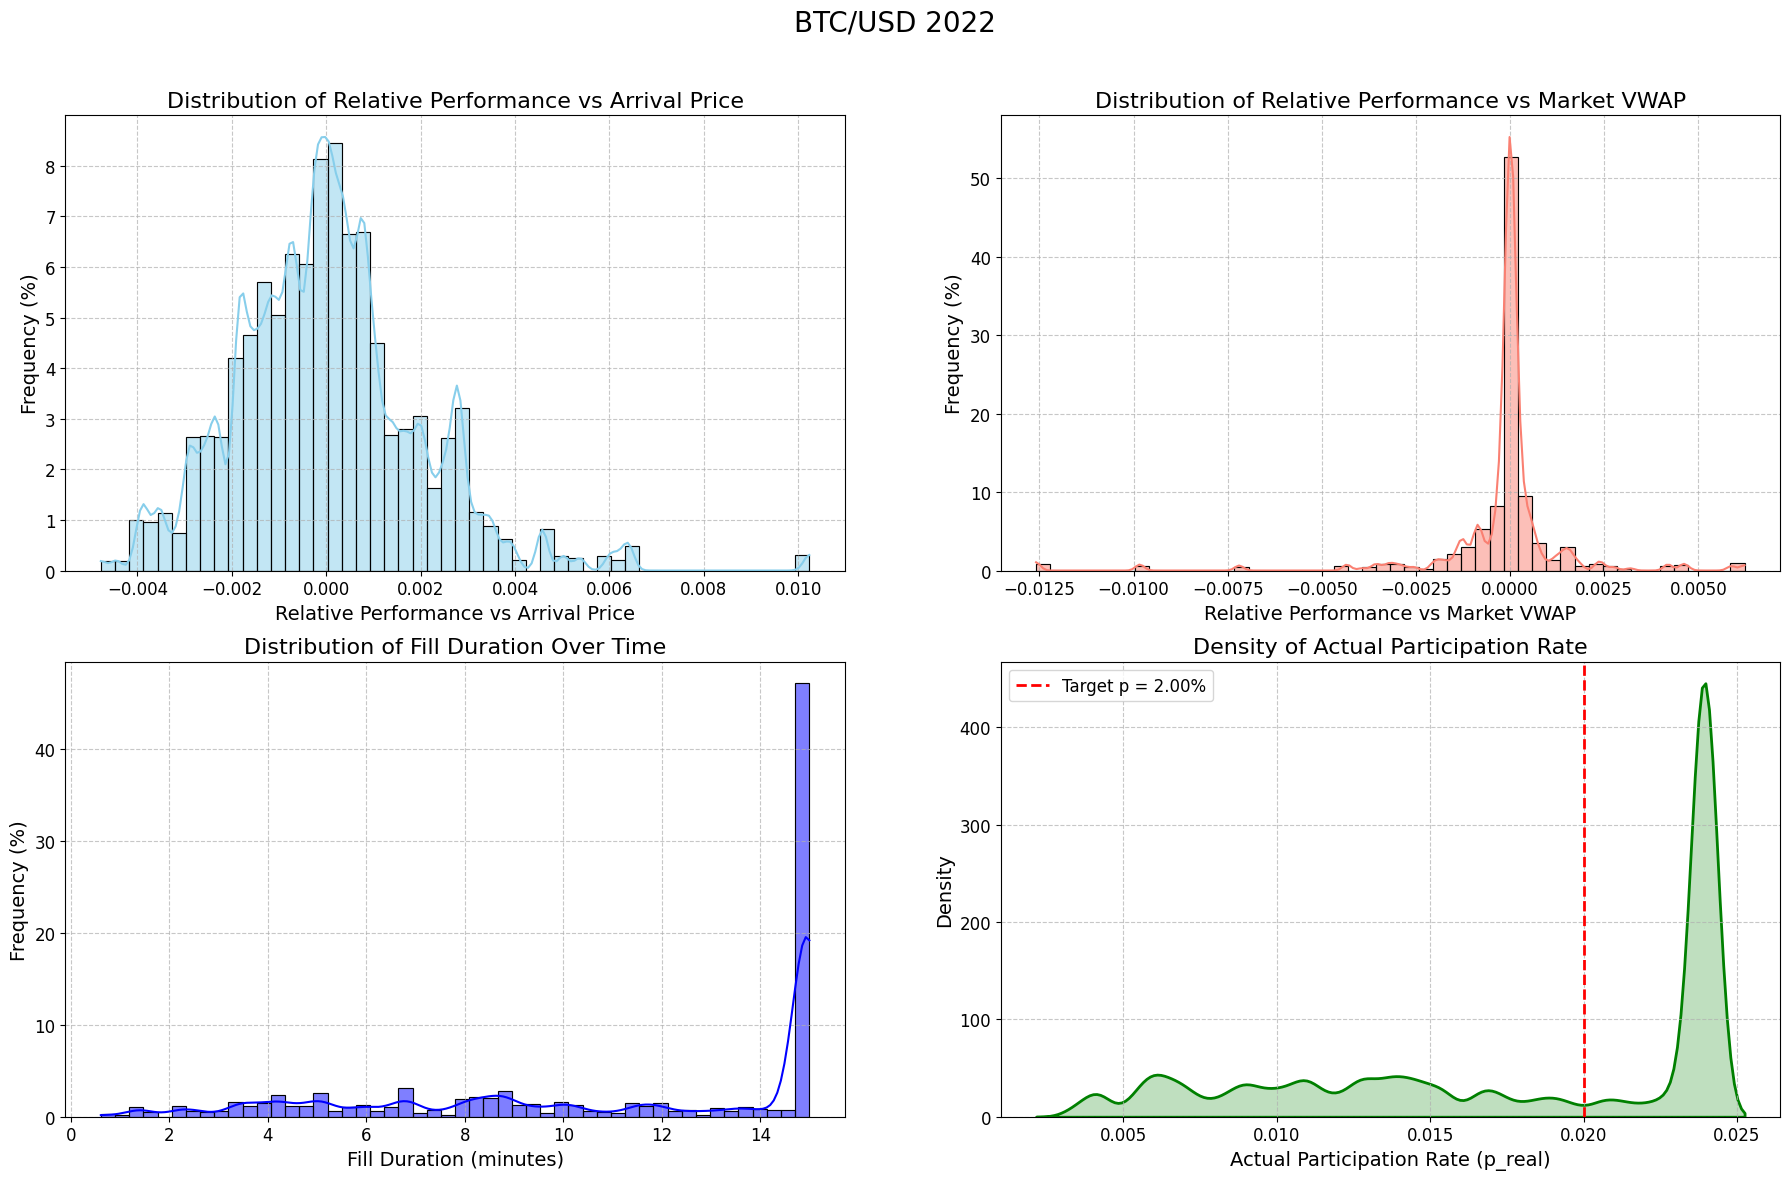

In [55]:
total = len(all_results_df)

plt.figure(figsize=(18, 12))

# 1. Histogram: Relative Performance vs Arrival Price
plt.subplot(2, 2, 1)
sns.histplot(data=all_results_df, x='rel_to_arrival', bins=50, kde=True, color='skyblue', edgecolor='black', weights=np.ones(total) * 100 / total)
plt.xlabel('Relative Performance vs Arrival Price', fontsize=14)
plt.ylabel('Frequency (%)', fontsize=14)
plt.title('Distribution of Relative Performance vs Arrival Price', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 2. Histogram: Relative Performance vs Market VWAP
plt.subplot(2, 2, 2)
sns.histplot(data=all_results_df, x='rel_to_market', bins=50, kde=True, color='salmon', edgecolor='black', weights=np.ones(total) * 100 / total)
plt.xlabel('Relative Performance vs Market VWAP', fontsize=14)
plt.ylabel('Frequency (%)', fontsize=14)
plt.title('Distribution of Relative Performance vs Market VWAP', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 3. Histogram: Fill Duration (minutes)
plt.subplot(2, 2, 3)
sns.histplot(data=all_results_df, x='fill_duration_min', bins=50, kde=True, color='blue', edgecolor='black', weights=np.ones(total) * 100 / total)
plt.xlabel('Fill Duration (minutes)', fontsize=14)
plt.ylabel('Frequency (%)', fontsize=14)
plt.title('Distribution of Fill Duration Over Time', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 4. Density Plot: Actual Participation (p_real) with Target p
plt.subplot(2, 2, 4)
sns.kdeplot(data=all_results_df, x='p_real', fill=True, color='green', linewidth=2)
plt.axvline(x=all_results_df['target_p'].iloc[0], color='red', linestyle='--', linewidth=2,
            label=f"Target p = {all_results_df['target_p'].iloc[0]:.2%}")
plt.xlabel('Actual Participation Rate (p_real)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Density of Actual Participation Rate', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.suptitle('BTC/USD 2022', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()


## Varying parameters

In this section I proceed with a different approach. I want to test how our different parameters affect the results of the accumulation algorithm.

- I test if changes in the parameters of participation p and adjusted participation k(p) affect the accumulation rates

- We found that there is a positive relationship between the participation and the accumulation rates. That is, how 'aggressive' we are in the market, affect how much of our desired quantities we can fill. 


In [56]:
# Define a grid of p values
p_values = [0.010, 0.012, 0.015, 0.018, 0.021, 0.024, 0.027]
years = [2022, 2023]
results_list = []

for year in years:
    df = globals()[f'BTC_USD_trades_{year}']
    for p_val in p_values:
        sim_result = simulate_vwap_in_time_windows(
            df=df,
            Q=Q,
            p=p_val,
            g=g,
            window='15Min',
            pair='BTC-USD',
            pause_seconds=3.0
        )
        # Add columns to indicate the parameters used.
        sim_result['p'] = p_val  
        # Also add the effective k.
        sim_result['k'] = min(p_val * 1.5, 0.05)
        sim_result['year'] = year  
        results_list.append(sim_result)

all_results_multi_p = pd.concat(results_list, ignore_index=True)

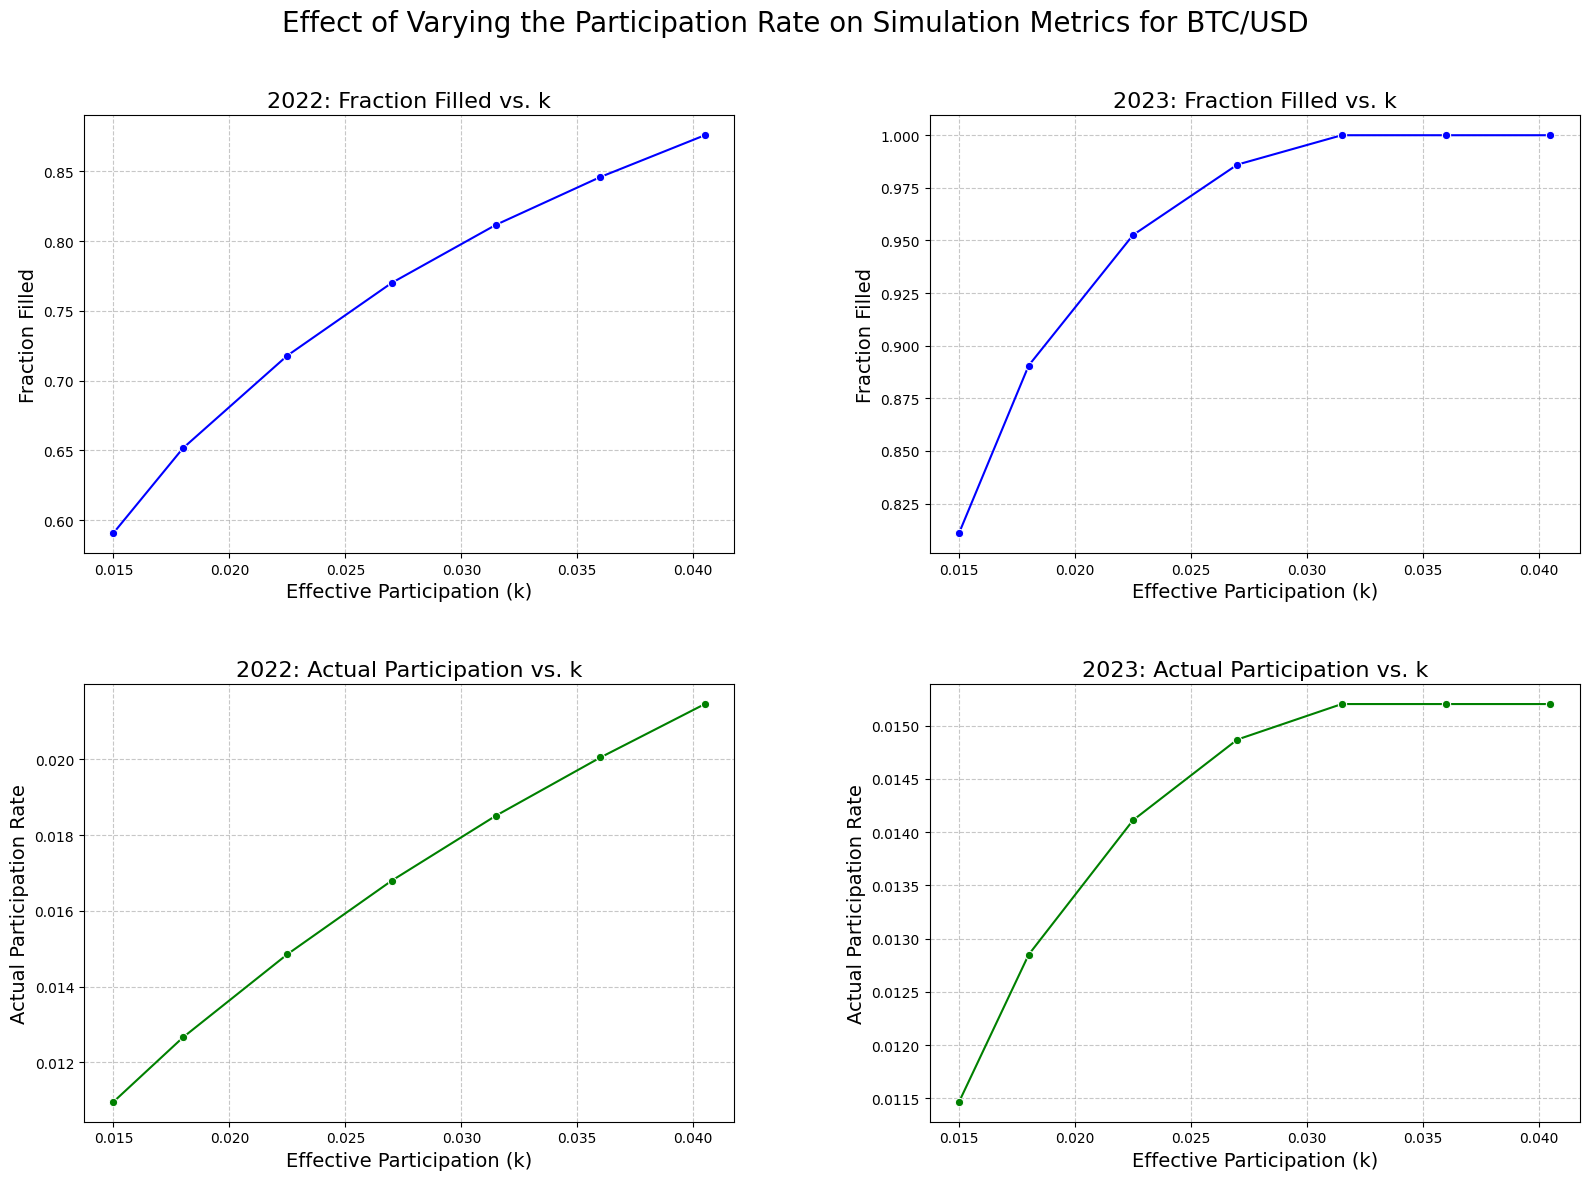

In [57]:
# Now, for each year, we want to plot the average Fraction Filled and p_real versus k.
# We compute the mean value for each unique k for each year.
summary = all_results_multi_p.groupby(['year', 'k']).agg({
    'fraction_filled': 'mean',
    'p_real': 'mean'
}).reset_index()

# Create a 2x2 figure.
plt.figure(figsize=(16, 12))

# Top-left: Fraction Filled vs k for 2022
plt.subplot(2, 2, 1)
data_2022 = summary[summary['year'] == 2022]
sns.lineplot(data=data_2022, x='k', y='fraction_filled', marker='o', color='blue')
plt.xlabel('Effective Participation (k)', fontsize=14)
plt.ylabel('Fraction Filled', fontsize=14)
plt.title('2022: Fraction Filled vs. k', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)

# Top-right: Fraction Filled vs k for 2023
plt.subplot(2, 2, 2)
data_2023 = summary[summary['year'] == 2023]
sns.lineplot(data=data_2023, x='k', y='fraction_filled', marker='o', color='blue')
plt.xlabel('Effective Participation (k)', fontsize=14)
plt.ylabel('Fraction Filled', fontsize=14)
plt.title('2023: Fraction Filled vs. k', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)

# Bottom-left: Actual Participation vs k for 2022
plt.subplot(2, 2, 3)
sns.lineplot(data=data_2022, x='k', y='p_real', marker='o', color='green')
plt.xlabel('Effective Participation (k)', fontsize=14)
plt.ylabel('Actual Participation Rate', fontsize=14)
plt.title('2022: Actual Participation vs. k', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)

# Bottom-right: Actual Participation vs k for 2023
plt.subplot(2, 2, 4)
sns.lineplot(data=data_2023, x='k', y='p_real', marker='o', color='green')
plt.xlabel('Effective Participation (k)', fontsize=14)
plt.ylabel('Actual Participation Rate', fontsize=14)
plt.title('2023: Actual Participation vs. k', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)

plt.suptitle('Effect of Varying the Participation Rate on Simulation Metrics for BTC/USD', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

### Performance metrics with different levels of 'aggressiveness'

- Given our results of the effect of participation, I decided to consider three values of the desired participation. 

- When we have a wide amount of data available, that is, when we are trading consistently, our results distribution on the relevant measures look very similar. However, when we have few trades, the relation is not very clear.

In [58]:
# Define a grid of p values
p_values = [0.012, 0.018, 0.025]
years = [2022, 2023]
results_list = []

for year in years:
    df = globals()[f'BTC_USD_trades_{year}']
    for p_val in p_values:
        sim_result = simulate_vwap_in_time_windows(
            df=df,
            Q=Q,
            p=p_val,
            g=g,
            window='15Min',
            pair='BTC-USD',
            pause_seconds=3.0
        )
        # Add columns to indicate the parameters used.
        sim_result['p'] = p_val  
        # Also add the effective k.
        sim_result['k'] = min(p_val * 1.5, 0.05)
        sim_result['year'] = year  
        results_list.append(sim_result)

all_results_multi_p = pd.concat(results_list, ignore_index=True)

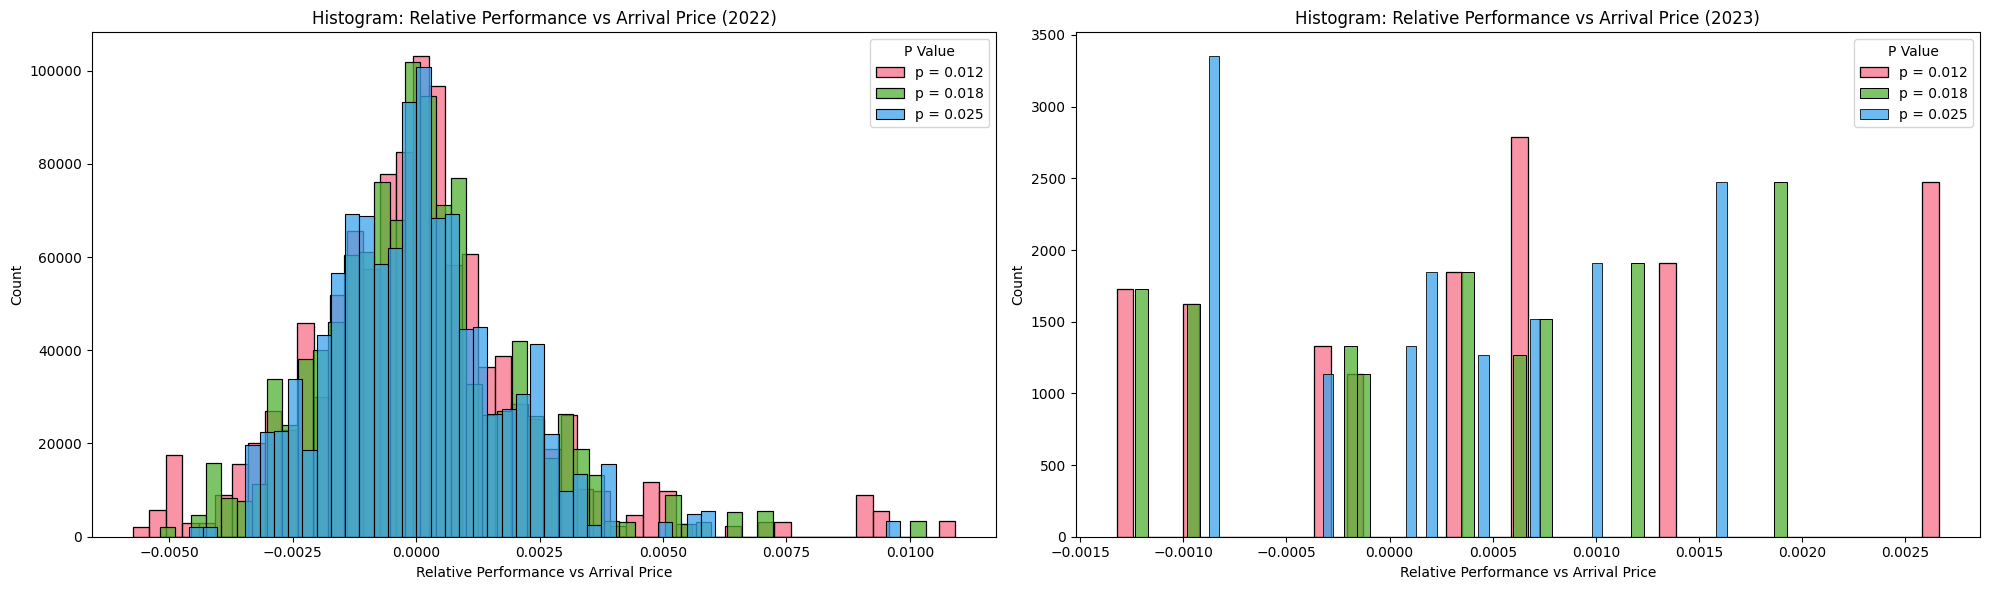

In [59]:
# --- 1. Histogram: Relative Performance vs Arrival Price ---
plt.figure(figsize=(20, 6))

colors = sns.color_palette("husl", len(p_values))  # Generate a color palette

plt.subplot(1, 2, 1)
for p_val, color in zip(p_values, colors):
    sns.histplot(data=all_results_multi_p[(all_results_multi_p['year'] == 2022) & (all_results_multi_p['p'] == p_val)], 
                 x='rel_to_arrival', bins=50, kde=False, color=color, label=f'p = {p_val:.3f}')
plt.xlabel('Relative Performance vs Arrival Price')
plt.title('Histogram: Relative Performance vs Arrival Price (2022)')
plt.legend(title='P Value')

plt.subplot(1, 2, 2)
for p_val, color in zip(p_values, colors):
    sns.histplot(data=all_results_multi_p[(all_results_multi_p['year'] == 2023) & (all_results_multi_p['p'] == p_val)], 
                 x='rel_to_arrival', bins=50, kde=False, color=color, label=f'p = {p_val:.3f}')
plt.xlabel('Relative Performance vs Arrival Price')
plt.title('Histogram: Relative Performance vs Arrival Price (2023)')
plt.legend(title='P Value')

plt.tight_layout()
plt.show()

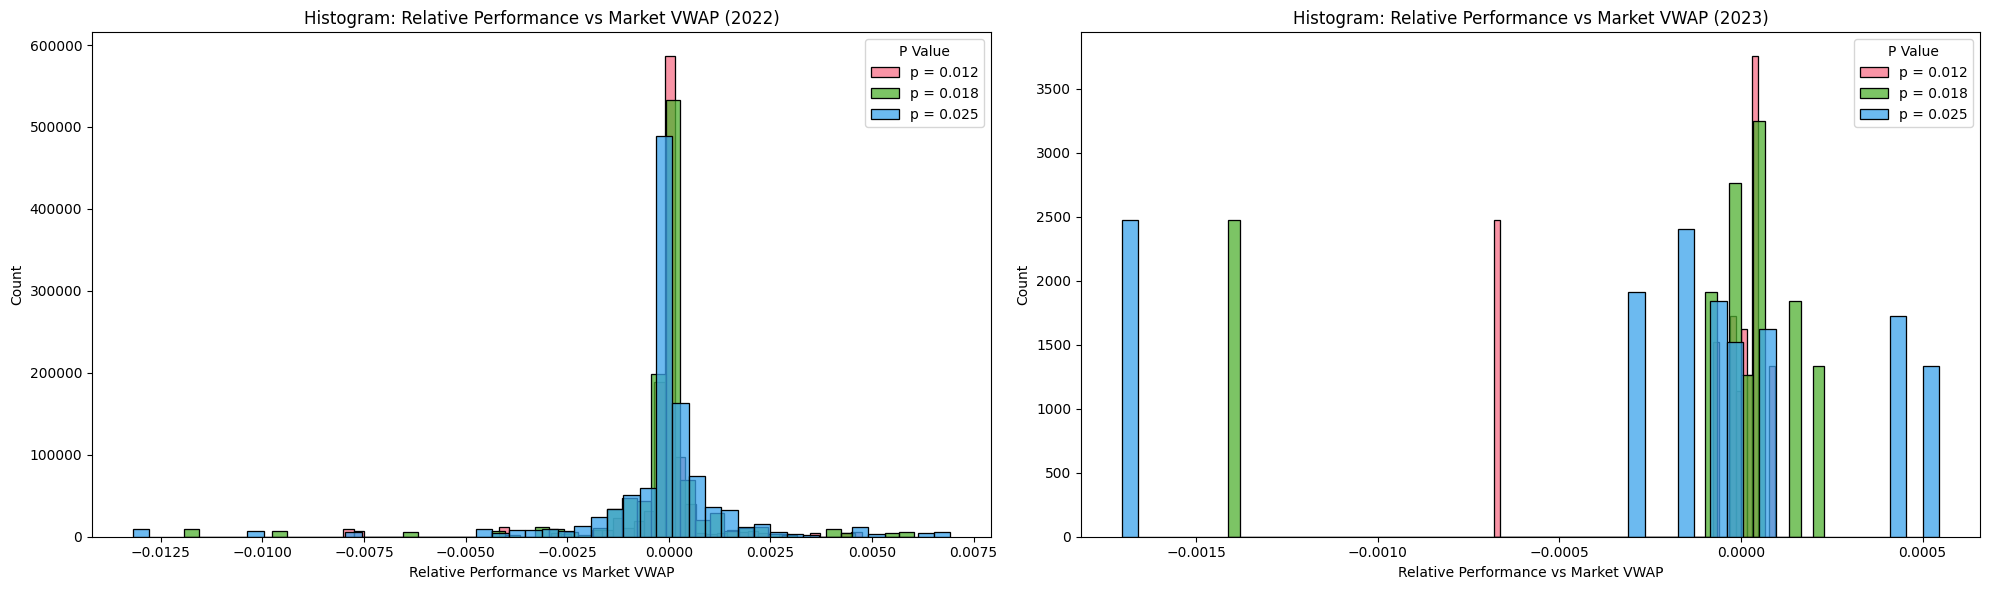

In [60]:
# --- 2. Histogram: Relative Performance vs Market VWAP ---
plt.figure(figsize=(20, 6))

colors = sns.color_palette("husl", len(p_values))  # Generate a color palette

plt.subplot(1, 2, 1)
for p_val, color in zip(p_values, colors):
    sns.histplot(data=all_results_multi_p[(all_results_multi_p['year'] == 2022) & (all_results_multi_p['p'] == p_val)], 
                 x='rel_to_market', bins=50, kde=False, color=color, label=f'p = {p_val:.3f}')
plt.xlabel('Relative Performance vs Market VWAP')
plt.title('Histogram: Relative Performance vs Market VWAP (2022)')
plt.legend(title='P Value')

plt.subplot(1, 2, 2)
for p_val, color in zip(p_values, colors):
    sns.histplot(data=all_results_multi_p[(all_results_multi_p['year'] == 2023) & (all_results_multi_p['p'] == p_val)], 
                 x='rel_to_market', bins=50, kde=False, color=color, label=f'p = {p_val:.3f}')
plt.xlabel('Relative Performance vs Market VWAP')
plt.title('Histogram: Relative Performance vs Market VWAP (2023)')
plt.legend(title='P Value')

plt.tight_layout()
plt.show()


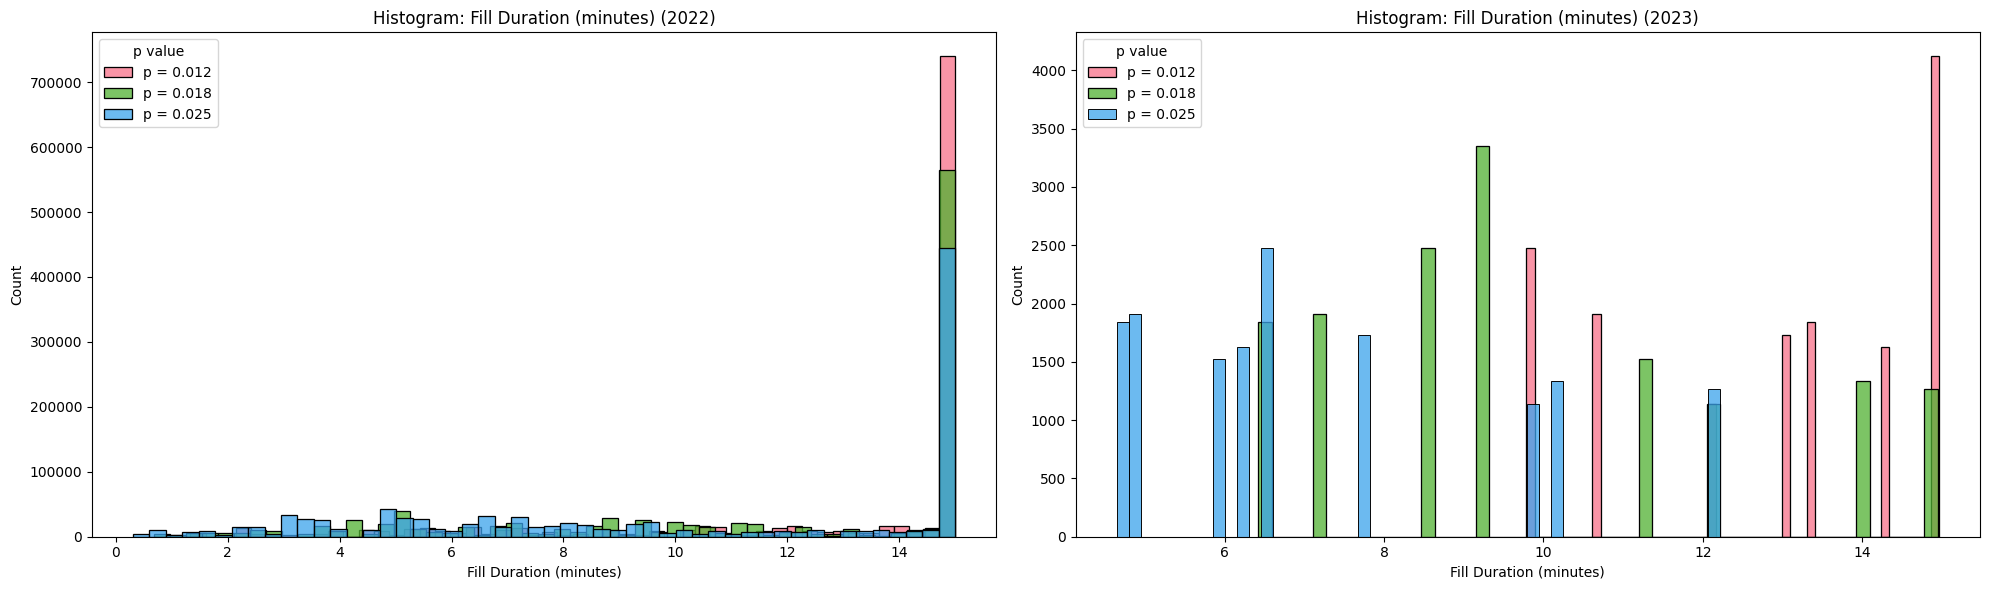

In [61]:
# --- 3. Histogram: Fill Duration (in minutes) ---
plt.figure(figsize=(20, 6))

colors = sns.color_palette("husl", len(p_values))  # Generate a color palette

plt.subplot(1, 2, 1)
for p_val, color in zip(p_values, colors):
    sns.histplot(data=all_results_multi_p[(all_results_multi_p['year'] == 2022) & (all_results_multi_p['p'] == p_val)], 
                 x='fill_duration_min', bins=50, kde=False, color=color, label=f'p = {p_val:.3f}')
plt.xlabel('Fill Duration (minutes)')
plt.title('Histogram: Fill Duration (minutes) (2022)')
plt.legend(title='p value')

plt.subplot(1, 2, 2)
for p_val, color in zip(p_values, colors):
    sns.histplot(data=all_results_multi_p[(all_results_multi_p['year'] == 2023) & (all_results_multi_p['p'] == p_val)], 
                 x='fill_duration_min', bins=50, kde=False, color=color, label=f'p = {p_val:.3f}')
plt.xlabel('Fill Duration (minutes)')
plt.title('Histogram: Fill Duration (minutes) (2023)')
plt.legend(title='p value')

plt.tight_layout()
plt.show()


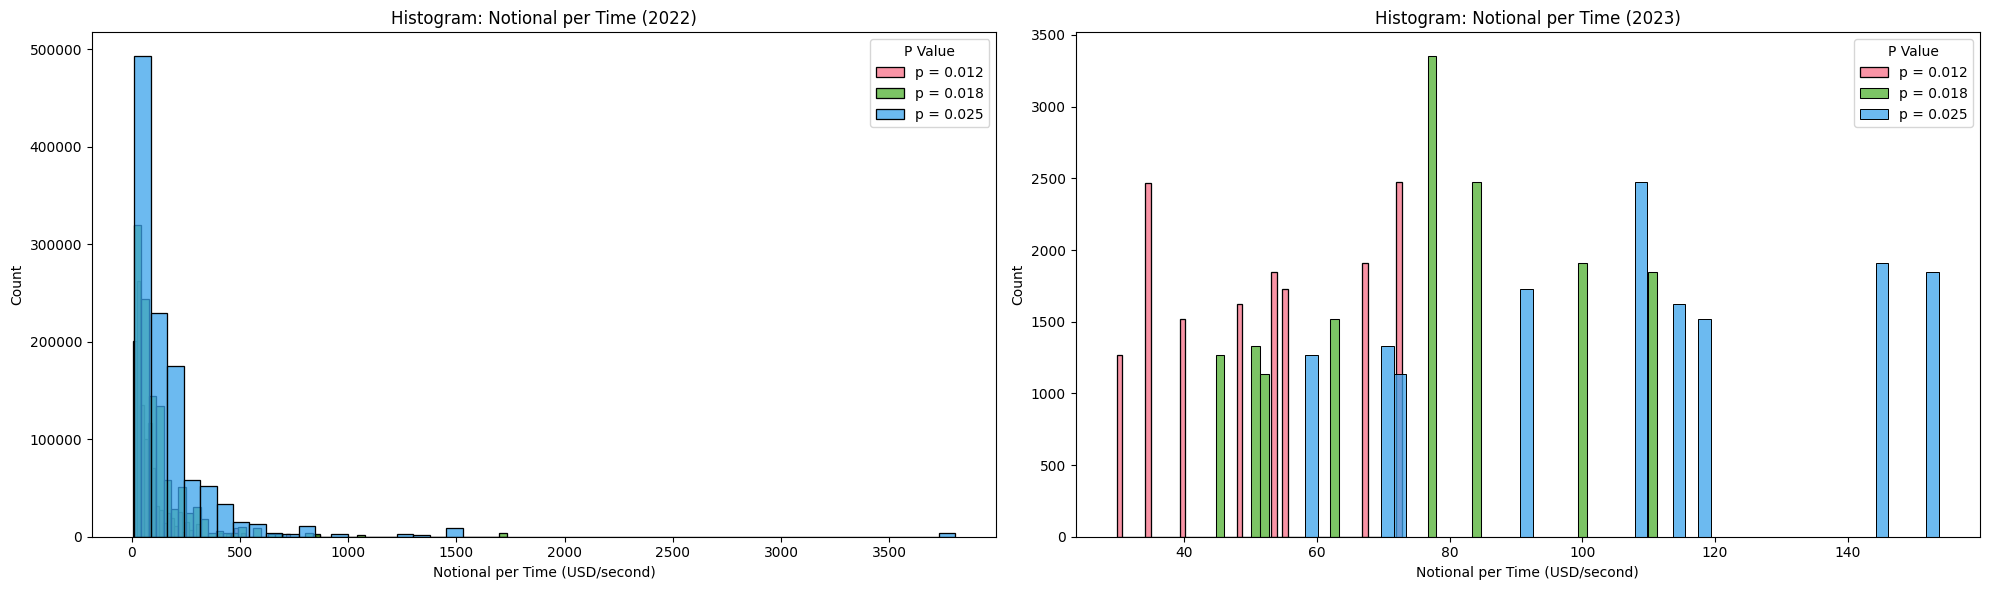

In [62]:
# --- 5. Histogram: Notional per Time ---
plt.figure(figsize=(20, 6))

colors = sns.color_palette("husl", len(p_values))  # Generate a color palette

plt.subplot(1, 2, 1)
for p_val, color in zip(p_values, colors):
    sns.histplot(data=all_results_multi_p[(all_results_multi_p['year'] == 2022) & (all_results_multi_p['p'] == p_val)], 
                 x='notional_per_time', bins=50, kde=False, color=color, label=f'p = {p_val:.3f}')
plt.xlabel('Notional per Time (USD/second)')
plt.title('Histogram: Notional per Time (2022)')
plt.legend(title='P Value')

plt.subplot(1, 2, 2)
for p_val, color in zip(p_values, colors):
    sns.histplot(data=all_results_multi_p[(all_results_multi_p['year'] == 2023) & (all_results_multi_p['p'] == p_val)], 
                 x='notional_per_time', bins=50, kde=False, color=color, label=f'p = {p_val:.3f}')
plt.xlabel('Notional per Time (USD/second)')
plt.title('Histogram: Notional per Time (2023)')
plt.legend(title='P Value')

plt.tight_layout()
plt.show()

### ETH/USD Analysis

- In the BTC analysis we found some important relations between our 'aggressiveness', and the quantities we were filling. However, the effect on the main measures was nuanced at best. 
- In ETH, we found a similar pattern. The participation rate affect how much are we filling, and the relation is very clear. But we do not see any effect on the calculated metrics. 

- This highlights that in the crypto market, there is room to increase the participation rate to a less passive, and more aggressive strategy without suffering big impacts on the prices we can get. 

In [63]:
adjustment_k = 1.2
Q = compute_target_quantity(
    ETH_USD_trades_2022,
    freq='5Min',
    percentile=0.35,
    fraction=0.05
)

g = compute_minimum_threshold(ETH_USD_trades_2022, percentile=0.08)

p = 0.02  # 2%
# Adjust k for slippage or missed fills, but ensure it doesn't exceed 5%
k = min(p * adjustment_k, 0.05)

print("Computed Q:", Q, "ETH")
print("Minimum threshold g:", g, "ETH")
print("Participation rate p:", p)
print("Adjusted participation rate k:", k)

Computed Q: 43.807671849067845 ETH
Minimum threshold g: 0.001 ETH
Participation rate p: 0.02
Adjusted participation rate k: 0.024


In [64]:
results_df = vwap_participation_vectorized(
    df=ETH_USD_trades_2022,  # your DataFrame with the specified columns
    Q=Q,           # want to buy 10 BTC
    p=0.02,           # 2% participation rate
    g=g,      # min threshold in the same "SizeBillionths" scale
    pair='ETH-USD',    # fee logic
    print_summary=True,  # print summary
    pause_seconds=3.0  # pause duration
)

----------- VWAP Participation Results -----------
Pair: ETH-USD
Fee rate = 0.50%
Target Q = 43.8077   p = 2.00%, threshold g = 1.0000e-03
Total filled = 43.8077
VWAP Price (USD per BTC) = 2625.5130
Total Cost (USD) = 115017.6109
Total fees (USD) = 575.0881
Filled trades count = 3139
Time to fill (minutes) = 29.27
Actual participation (p_real) = 0.01%
------------------------------------------------



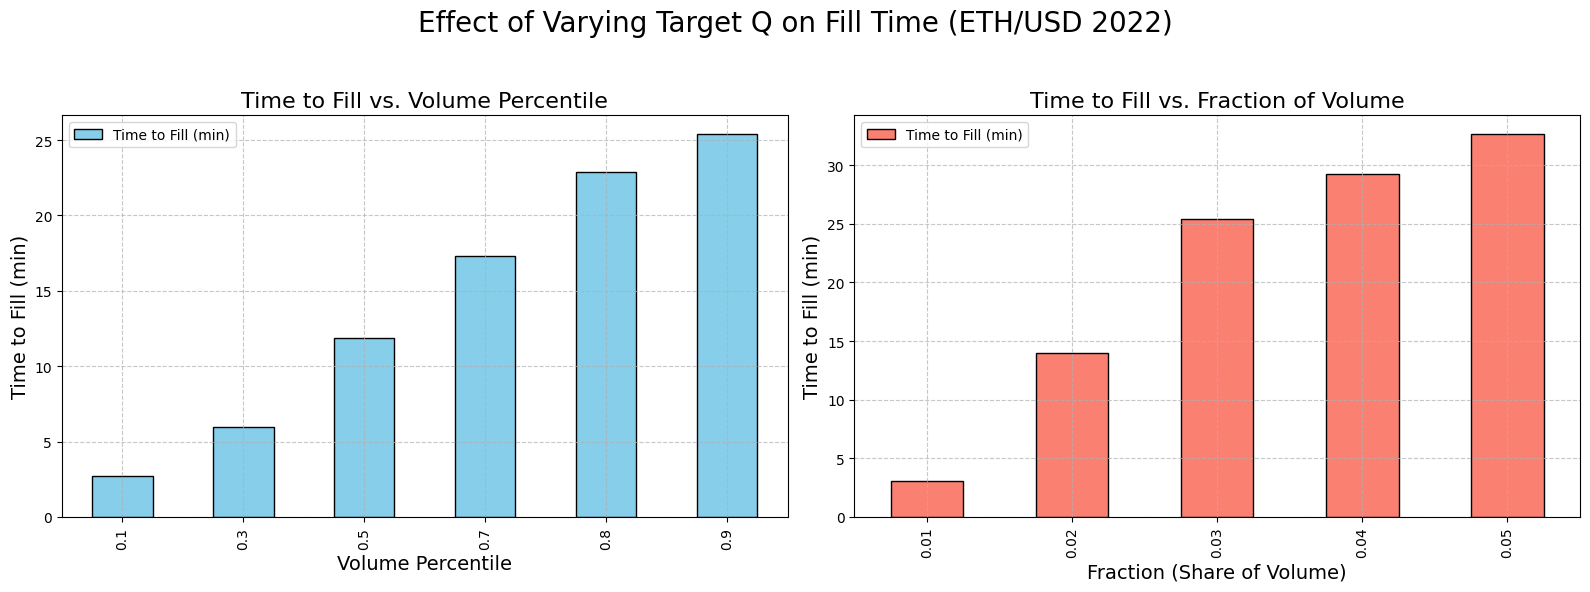

In [65]:
# Define a list of volume percentiles to try.
percentiles_to_try = [0.1, 0.3, 0.5, 0.7, 0.8, 0.9]
fixed_fraction = 0.02  # fixed share of the volume percentile

# List to store results as tuples: (volume_percentile, time_to_fill in minutes)
results_time_pct = []

for pct in percentiles_to_try:
    # Compute the target Q using your function.
    Q_val = compute_target_quantity(ETH_USD_trades_2022,
                                    freq='5Min',
                                    percentile=pct,
                                    fraction=fixed_fraction)
    # Run your simulation.
    sim_result = vwap_participation_vectorized(
        df=ETH_USD_trades_2022,
        Q=Q_val,
        p=p,
        g=g,
        pair='ETH-USD',
        print_summary=False,
        pause_seconds=3.0
    )
    # Extract the fill duration in minutes from the simulation.
    fill_time_min = sim_result['fill_duration_min'].iloc[0]
    results_time_pct.append((pct, fill_time_min))

# Convert the list to a DataFrame.
df_time_pct = pd.DataFrame(results_time_pct, columns=['Volume Percentile', 'Time to Fill (min)'])
df_time_pct.set_index('Volume Percentile', inplace=True)

# -------------------------------
# Part 2: Varying Fraction (with fixed volume percentile)
# -------------------------------

# Define a list of fraction values (share you take) to try.
fractions_to_try = [0.01, 0.02, 0.03, 0.04, 0.05]
fixed_percentile = 0.65  # fixed volume percentile

results_time_frac = []

for frac in fractions_to_try:
    Q_val = compute_target_quantity(ETH_USD_trades_2022,
                                    freq='5Min',
                                    percentile=fixed_percentile,
                                    fraction=frac)
    sim_result = vwap_participation_vectorized(
        df=ETH_USD_trades_2022,
        Q=Q_val,
        p=p,
        g=g,
        pair='ETH-USD',
        print_summary=False,
        pause_seconds=3.0
    )
    fill_time_min = sim_result['fill_duration_min'].iloc[0]
    results_time_frac.append((frac, fill_time_min))

df_time_frac = pd.DataFrame(results_time_frac, columns=['Fraction', 'Time to Fill (min)'])
df_time_frac.set_index('Fraction', inplace=True)

# -------------------------------
# Plotting the Two Bar Graphs Side by Side
# -------------------------------

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Time to Fill vs. Volume Percentile
df_time_pct.plot(kind='bar', ax=axs[0], color='skyblue', edgecolor='black')
axs[0].set_xlabel("Volume Percentile", fontsize=14)
axs[0].set_ylabel("Time to Fill (min)", fontsize=14)
axs[0].set_title("Time to Fill vs. Volume Percentile", fontsize=16)
axs[0].grid(True, linestyle='--', alpha=0.7)

# Plot 2: Time to Fill vs. Fraction (Share of Volume)
df_time_frac.plot(kind='bar', ax=axs[1], color='salmon', edgecolor='black')
axs[1].set_xlabel("Fraction (Share of Volume)", fontsize=14)
axs[1].set_ylabel("Time to Fill (min)", fontsize=14)
axs[1].set_title("Time to Fill vs. Fraction of Volume", fontsize=16)
axs[1].grid(True, linestyle='--', alpha=0.7)

plt.suptitle("Effect of Varying Target Q on Fill Time (ETH/USD 2022)", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()


In [66]:
all_results_multi_p = simulate_vwap_in_time_windows(
    df=ETH_USD_trades_2022,  # your DataFrame with the specified columns
    Q=Q,           # want to buy 10 ETH
    p=0.02,           # 2% participation rate
    g=g,      # min threshold in the same "SizeBillionths" scale
    window='15Min',  # time window for each simulation
    pair='ETH-USD',    # fee logic
    pause_seconds=3.0  # pause duration
)

In [67]:
summary_by_window = (
    all_results_df
    .groupby('window_start_time')
    .agg({
       'fill_qty':'sum',
       'cost_usd':'sum',
       'fee_usd':'sum',
       'arrival_price':'first',  # The arrival price was constant in each window
       'avg_fill_price':'mean',  # It's the same within a single window, but we can do 'first'
    })
)

summary_by_window.head(8)

,fill_qty,cost_usd,fee_usd,arrival_price,avg_fill_price
window_start_time,,,,,
2022-01-29 21:00:00,1.85613,71627.33971,358.13670,38383.38000,38589.59489
2022-01-29 21:15:00,1.46766,56633.46668,283.16733,38587.70000,38587.61368
2022-01-29 21:30:00,1.71800,66173.59459,330.86797,38579.91000,38517.85129
2022-01-29 21:45:00,0.84095,32341.64142,161.70821,38426.92000,38458.60855
2022-01-29 22:00:00,1.83372,70163.49563,350.81748,38384.64000,38262.84625
2022-01-29 22:15:00,1.85613,70879.06251,354.39531,38201.97000,38186.45673
2022-01-29 22:30:00,1.19930,45695.04668,228.47523,38097.11000,38101.47814
2022-01-29 22:45:00,1.44477,55121.74830,275.60874,38191.48000,38152.48512


In [68]:
window_summary = all_results_df.groupby('window_start_time').agg({
    'arrival_price': 'first',
    'market_vwap': 'first',
    'avg_fill_price': 'first',
    'fill_duration_seconds': 'first',
    'cost_usd': 'sum',
    'fee_usd': 'sum',
    'fraction_filled': 'first',      # Assuming constant per window
    'order_filled': 'first',
    'order_in_time': 'first',
    'notional_per_time': 'first',
    'trading_cost_ratio': 'first',
    'rel_to_arrival': 'first',
    'rel_to_market': 'first'
}).reset_index()

window_summary.head(8)

,window_start_time,arrival_price,market_vwap,avg_fill_price,fill_duration_seconds,cost_usd,fee_usd,fraction_filled,order_filled,order_in_time,notional_per_time,trading_cost_ratio,rel_to_arrival,rel_to_market
0,2022-01-29 21:00:00,38383.38000,38585.30501,38589.59489,703.25957,71627.33971,358.13670,1.00000,True,True,101.85050,0.00500,0.00537,0.00011
1,2022-01-29 21:15:00,38587.70000,38589.03813,38587.61368,898.40080,56633.46668,283.16733,0.79071,False,True,63.03809,0.00500,-0.00000,-0.00004
2,2022-01-29 21:30:00,38579.91000,38513.97194,38517.85129,898.91826,66173.59459,330.86797,0.92558,False,True,73.61470,0.00500,-0.00161,0.00010
3,2022-01-29 21:45:00,38426.92000,38450.29627,38458.60855,897.55462,32341.64142,161.70821,0.45306,False,True,36.03306,0.00500,0.00082,0.00022
4,2022-01-29 22:00:00,38384.64000,38266.87536,38262.84625,899.40090,70163.49563,350.81748,0.98793,False,True,78.01137,0.00500,-0.00317,-0.00011
5,2022-01-29 22:15:00,38201.97000,38151.83751,38186.45673,849.85687,70879.06251,354.39531,1.00000,True,True,83.40118,0.00500,-0.00041,0.00091
6,2022-01-29 22:30:00,38097.11000,38094.12205,38101.47814,899.59808,45695.04668,228.47523,0.64613,False,True,50.79496,0.00500,0.00011,0.00019
7,2022-01-29 22:45:00,38191.48000,38156.35524,38152.48512,897.86839,55121.74830,275.60874,0.77838,False,True,61.39179,0.00500,-0.00102,-0.00010


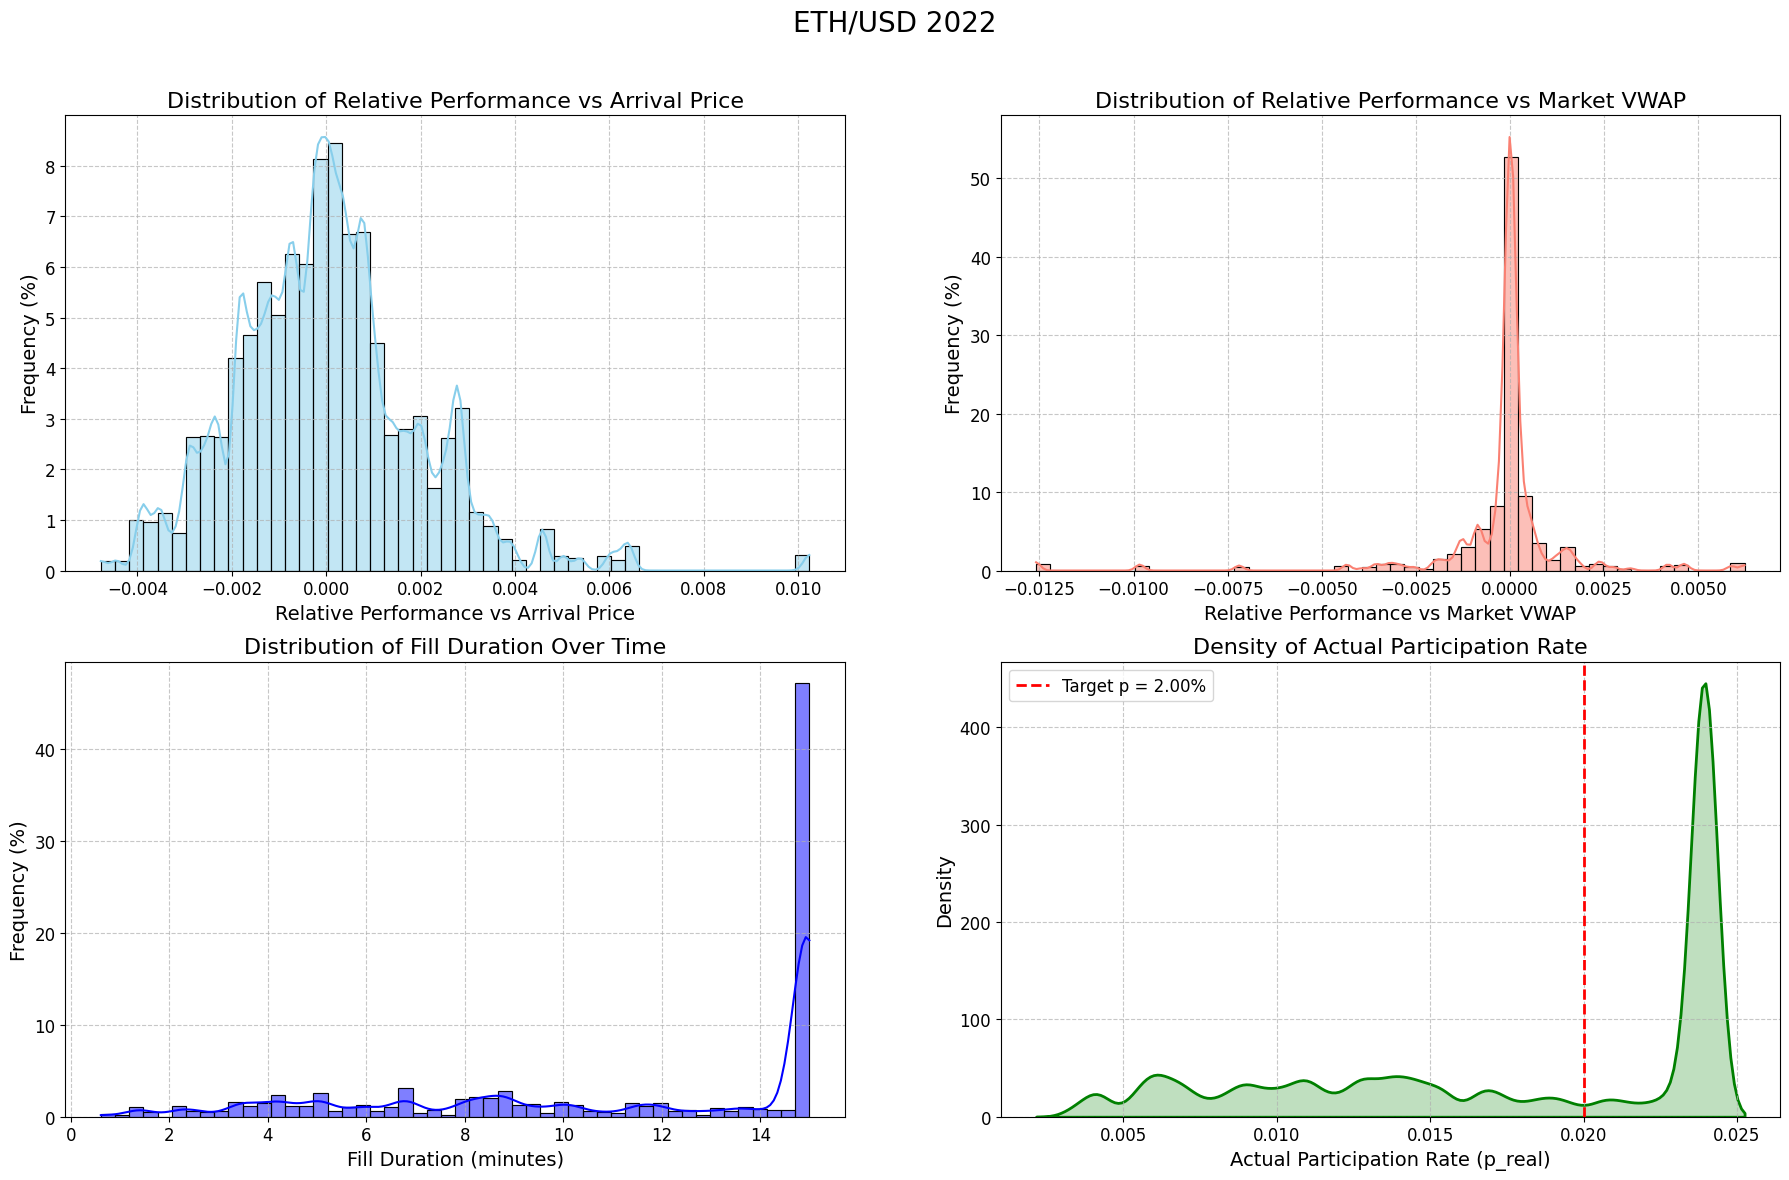

In [69]:
total = len(all_results_df)

plt.figure(figsize=(18, 12))

# 1. Histogram: Relative Performance vs Arrival Price
plt.subplot(2, 2, 1)
sns.histplot(data=all_results_df, x='rel_to_arrival', bins=50, kde=True, color='skyblue', edgecolor='black', weights=np.ones(total) * 100 / total)
plt.xlabel('Relative Performance vs Arrival Price', fontsize=14)
plt.ylabel('Frequency (%)', fontsize=14)
plt.title('Distribution of Relative Performance vs Arrival Price', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 2. Histogram: Relative Performance vs Market VWAP
plt.subplot(2, 2, 2)
sns.histplot(data=all_results_df, x='rel_to_market', bins=50, kde=True, color='salmon', edgecolor='black', weights=np.ones(total) * 100 / total)
plt.xlabel('Relative Performance vs Market VWAP', fontsize=14)
plt.ylabel('Frequency (%)', fontsize=14)
plt.title('Distribution of Relative Performance vs Market VWAP', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 3. Histogram: Fill Duration (minutes)
plt.subplot(2, 2, 3)
sns.histplot(data=all_results_df, x='fill_duration_min', bins=50, kde=True, color='blue', edgecolor='black', weights=np.ones(total) * 100 / total)
plt.xlabel('Fill Duration (minutes)', fontsize=14)
plt.ylabel('Frequency (%)', fontsize=14)
plt.title('Distribution of Fill Duration Over Time', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 4. Density Plot: Actual Participation (p_real) with Target p
plt.subplot(2, 2, 4)
sns.kdeplot(data=all_results_df, x='p_real', fill=True, color='green', linewidth=2)
plt.axvline(x=all_results_df['target_p'].iloc[0], color='red', linestyle='--', linewidth=2,
            label=f"Target p = {all_results_df['target_p'].iloc[0]:.2%}")
plt.xlabel('Actual Participation Rate (p_real)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Density of Actual Participation Rate', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.suptitle('ETH/USD 2022', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()


In [70]:
# Define a grid of p values
p_values = [0.010, 0.012, 0.015, 0.018, 0.021, 0.024, 0.027]
years = [2022, 2023]
results_list = []

for year in years:
    df = globals()[f'ETH_USD_trades_{year}']
    for p_val in p_values:
        sim_result = simulate_vwap_in_time_windows(
            df=df,
            Q=Q,
            p=p_val,
            g=g,
            window='15Min',
            pair='ETH-USD',
            pause_seconds=3.0
        )
        # Add columns to indicate the parameters used.
        sim_result['p'] = p_val  
        # Also add the effective k.
        sim_result['k'] = min(p_val * 1.5, 0.05)
        sim_result['year'] = year  
        results_list.append(sim_result)

all_results_multi_p = pd.concat(results_list, ignore_index=True)

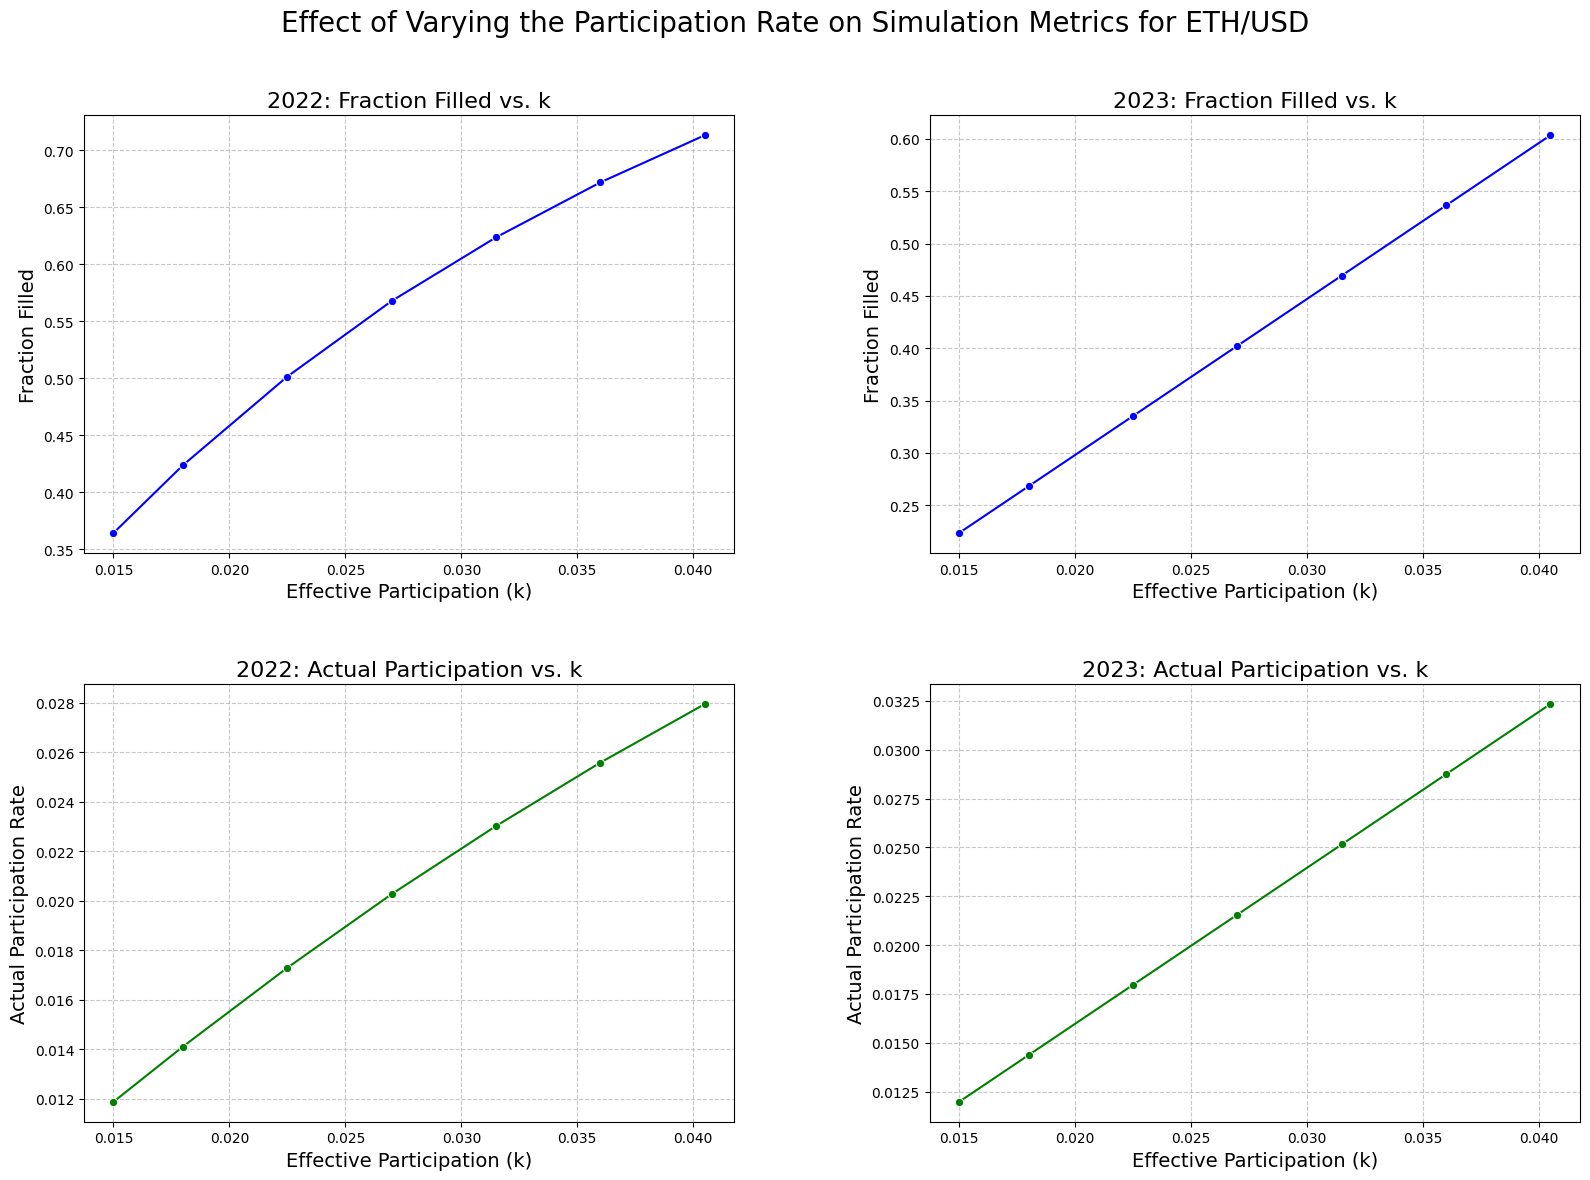

In [71]:
# Now, for each year, we want to plot the average Fraction Filled and p_real versus k.
# We compute the mean value for each unique k for each year.
summary = all_results_multi_p.groupby(['year', 'k']).agg({
    'fraction_filled': 'mean',
    'p_real': 'mean'
}).reset_index()

# Create a 2x2 figure.
plt.figure(figsize=(16, 12))

# Top-left: Fraction Filled vs k for 2022
plt.subplot(2, 2, 1)
data_2022 = summary[summary['year'] == 2022]
sns.lineplot(data=data_2022, x='k', y='fraction_filled', marker='o', color='blue')
plt.xlabel('Effective Participation (k)', fontsize=14)
plt.ylabel('Fraction Filled', fontsize=14)
plt.title('2022: Fraction Filled vs. k', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)

# Top-right: Fraction Filled vs k for 2023
plt.subplot(2, 2, 2)
data_2023 = summary[summary['year'] == 2023]
sns.lineplot(data=data_2023, x='k', y='fraction_filled', marker='o', color='blue')
plt.xlabel('Effective Participation (k)', fontsize=14)
plt.ylabel('Fraction Filled', fontsize=14)
plt.title('2023: Fraction Filled vs. k', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)

# Bottom-left: Actual Participation vs k for 2022
plt.subplot(2, 2, 3)
sns.lineplot(data=data_2022, x='k', y='p_real', marker='o', color='green')
plt.xlabel('Effective Participation (k)', fontsize=14)
plt.ylabel('Actual Participation Rate', fontsize=14)
plt.title('2022: Actual Participation vs. k', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)

# Bottom-right: Actual Participation vs k for 2023
plt.subplot(2, 2, 4)
sns.lineplot(data=data_2023, x='k', y='p_real', marker='o', color='green')
plt.xlabel('Effective Participation (k)', fontsize=14)
plt.ylabel('Actual Participation Rate', fontsize=14)
plt.title('2023: Actual Participation vs. k', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)

plt.suptitle('Effect of Varying the Participation Rate on Simulation Metrics for ETH/USD', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

In [72]:
# Define a grid of p values
p_values = [0.012, 0.018, 0.025]
years = [2022, 2023]
results_list = []

for year in years:
    df = globals()[f'ETH_USD_trades_{year}']
    for p_val in p_values:
        sim_result = simulate_vwap_in_time_windows(
            df=df,
            Q=Q,
            p=p_val,
            g=g,
            window='15Min',
            pair='ETH-USD',
            pause_seconds=3.0
        )
        # Add columns to indicate the parameters used.
        sim_result['p'] = p_val  
        # Also add the effective k.
        sim_result['k'] = min(p_val * 1.5, 0.05)
        sim_result['year'] = year  
        results_list.append(sim_result)

all_results_multi_p = pd.concat(results_list, ignore_index=True)

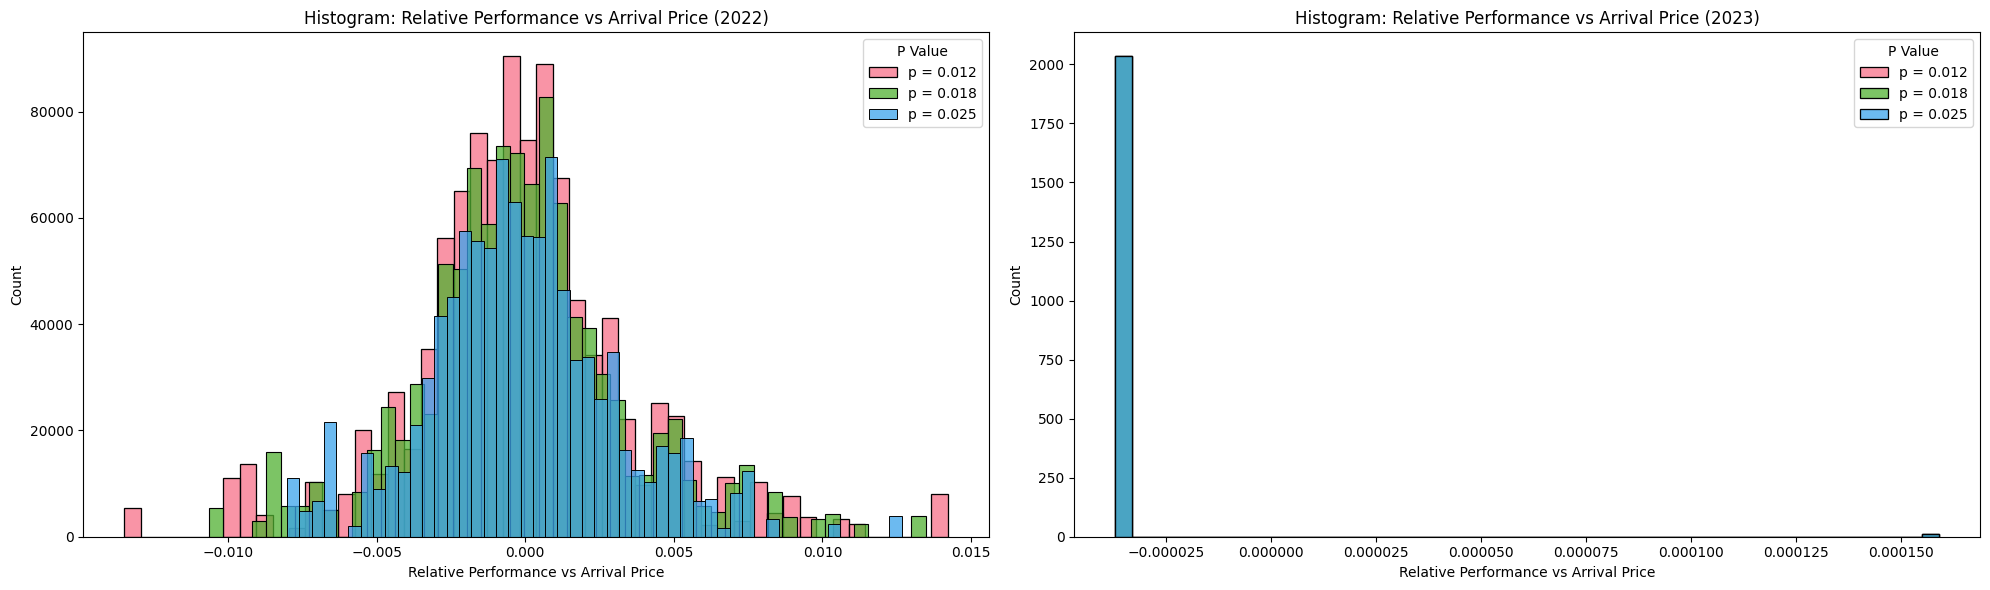

In [73]:
# --- 1. Histogram: Relative Performance vs Arrival Price ---
plt.figure(figsize=(20, 6))

colors = sns.color_palette("husl", len(p_values))  # Generate a color palette

plt.subplot(1, 2, 1)
for p_val, color in zip(p_values, colors):
    sns.histplot(data=all_results_multi_p[(all_results_multi_p['year'] == 2022) & (all_results_multi_p['p'] == p_val)], 
                 x='rel_to_arrival', bins=50, kde=False, color=color, label=f'p = {p_val:.3f}')
plt.xlabel('Relative Performance vs Arrival Price')
plt.title('Histogram: Relative Performance vs Arrival Price (2022)')
plt.legend(title='P Value')

plt.subplot(1, 2, 2)
for p_val, color in zip(p_values, colors):
    sns.histplot(data=all_results_multi_p[(all_results_multi_p['year'] == 2023) & (all_results_multi_p['p'] == p_val)], 
                 x='rel_to_arrival', bins=50, kde=False, color=color, label=f'p = {p_val:.3f}')
plt.xlabel('Relative Performance vs Arrival Price')
plt.title('Histogram: Relative Performance vs Arrival Price (2023)')
plt.legend(title='P Value')

plt.tight_layout()
plt.show()


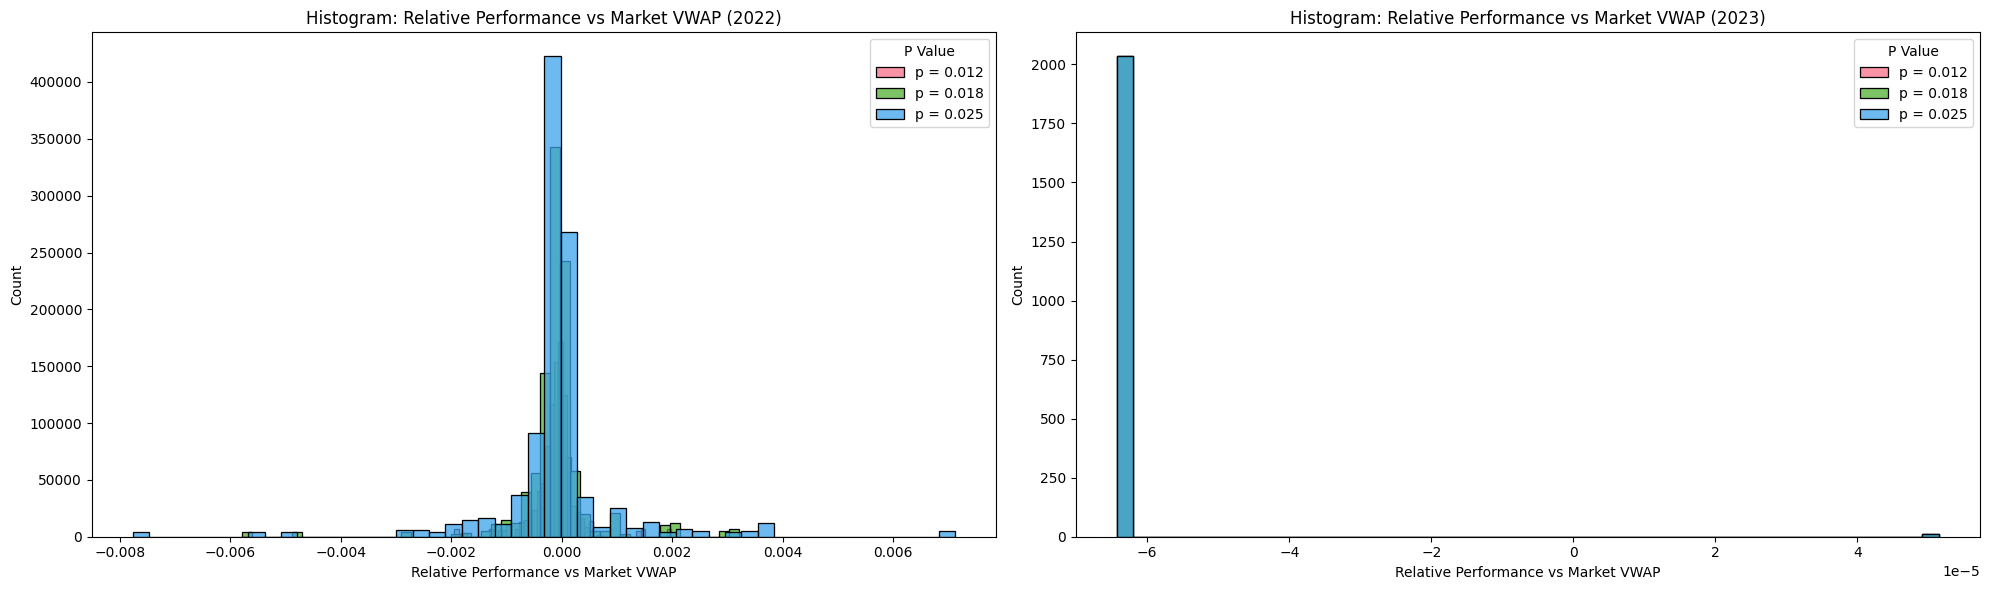

In [74]:
# --- 2. Histogram: Relative Performance vs Market VWAP ---
plt.figure(figsize=(20, 6))

colors = sns.color_palette("husl", len(p_values))  # Generate a color palette

plt.subplot(1, 2, 1)
for p_val, color in zip(p_values, colors):
    sns.histplot(data=all_results_multi_p[(all_results_multi_p['year'] == 2022) & (all_results_multi_p['p'] == p_val)], 
                 x='rel_to_market', bins=50, kde=False, color=color, label=f'p = {p_val:.3f}')
plt.xlabel('Relative Performance vs Market VWAP')
plt.title('Histogram: Relative Performance vs Market VWAP (2022)')
plt.legend(title='P Value')

plt.subplot(1, 2, 2)
for p_val, color in zip(p_values, colors):
    sns.histplot(data=all_results_multi_p[(all_results_multi_p['year'] == 2023) & (all_results_multi_p['p'] == p_val)], 
                 x='rel_to_market', bins=50, kde=False, color=color, label=f'p = {p_val:.3f}')
plt.xlabel('Relative Performance vs Market VWAP')
plt.title('Histogram: Relative Performance vs Market VWAP (2023)')
plt.legend(title='P Value')

plt.tight_layout()
plt.show()

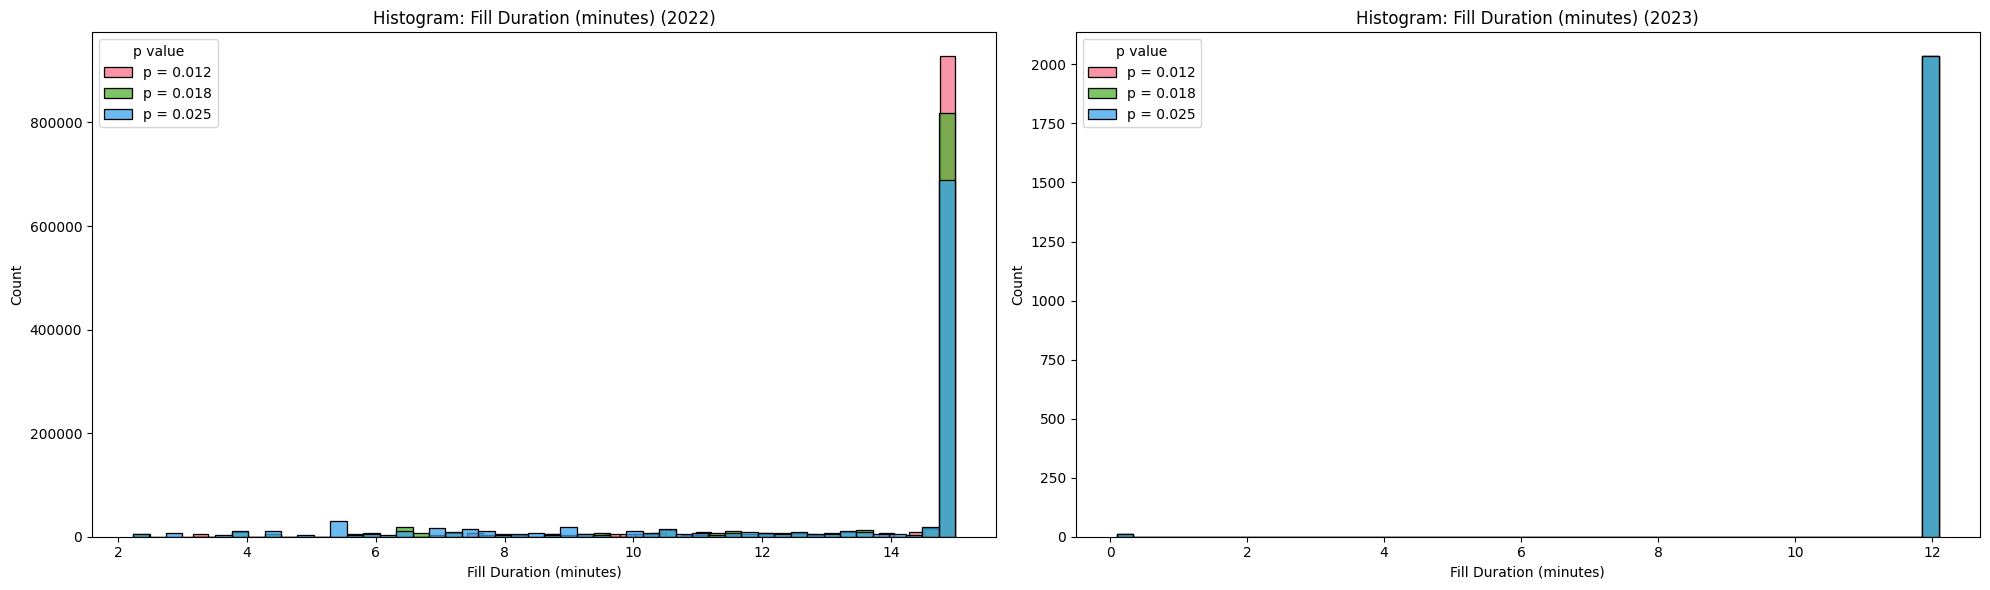

In [75]:
# --- 3. Histogram: Fill Duration (in minutes) ---
plt.figure(figsize=(20, 6))

colors = sns.color_palette("husl", len(p_values))  # Generate a color palette

plt.subplot(1, 2, 1)
for p_val, color in zip(p_values, colors):
    sns.histplot(data=all_results_multi_p[(all_results_multi_p['year'] == 2022) & (all_results_multi_p['p'] == p_val)], 
                 x='fill_duration_min', bins=50, kde=False, color=color, label=f'p = {p_val:.3f}')
plt.xlabel('Fill Duration (minutes)')
plt.title('Histogram: Fill Duration (minutes) (2022)')
plt.legend(title='p value')

plt.subplot(1, 2, 2)
for p_val, color in zip(p_values, colors):
    sns.histplot(data=all_results_multi_p[(all_results_multi_p['year'] == 2023) & (all_results_multi_p['p'] == p_val)], 
                 x='fill_duration_min', bins=50, kde=False, color=color, label=f'p = {p_val:.3f}')
plt.xlabel('Fill Duration (minutes)')
plt.title('Histogram: Fill Duration (minutes) (2023)')
plt.legend(title='p value')

plt.tight_layout()
plt.show()


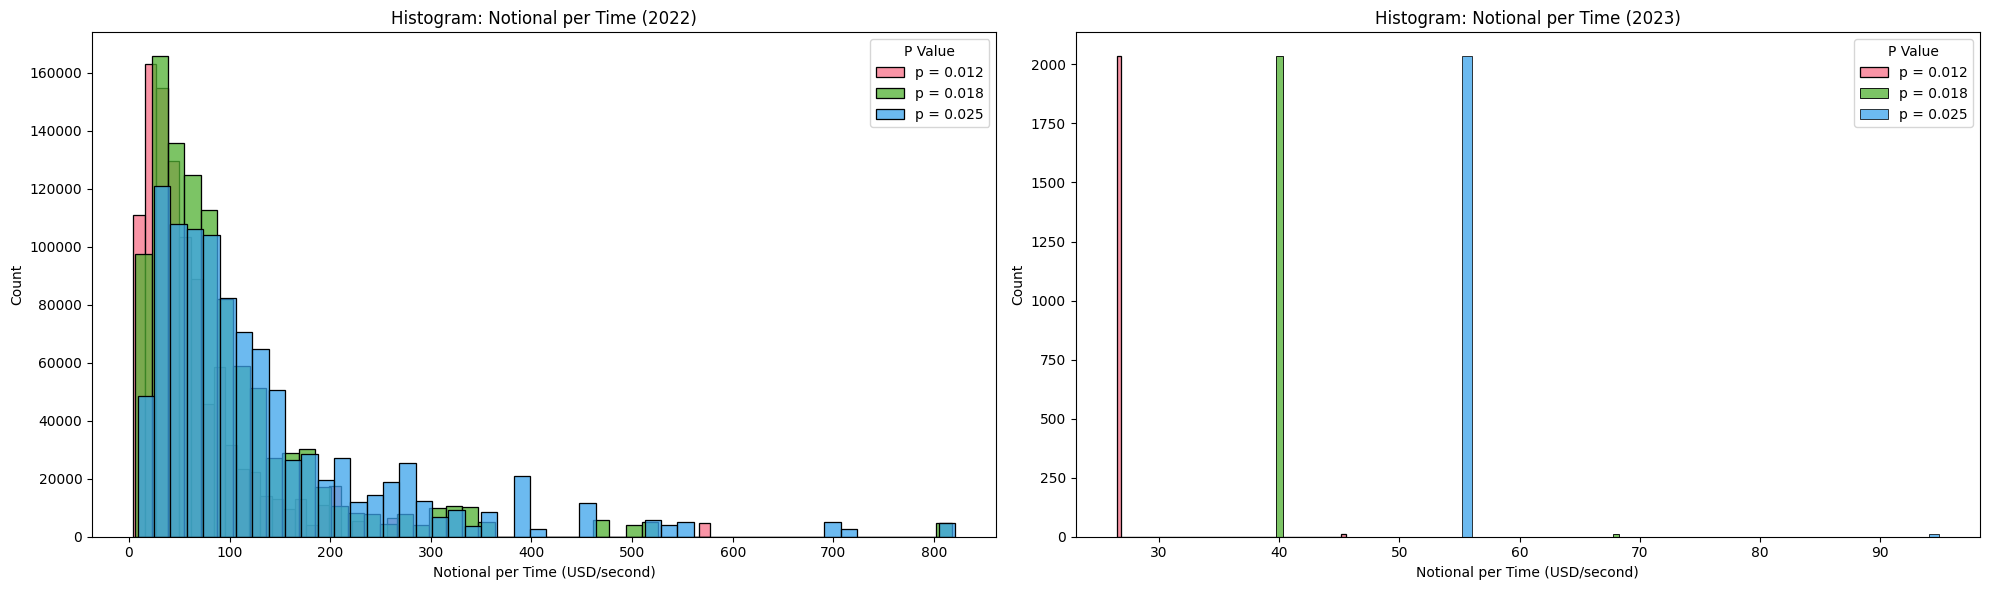

In [76]:
# --- 5. Histogram: Notional per Time ---
plt.figure(figsize=(20, 6))

colors = sns.color_palette("husl", len(p_values))  # Generate a color palette

plt.subplot(1, 2, 1)
for p_val, color in zip(p_values, colors):
    sns.histplot(data=all_results_multi_p[(all_results_multi_p['year'] == 2022) & (all_results_multi_p['p'] == p_val)], 
                 x='notional_per_time', bins=50, kde=False, color=color, label=f'p = {p_val:.3f}')
plt.xlabel('Notional per Time (USD/second)')
plt.title('Histogram: Notional per Time (2022)')
plt.legend(title='P Value')

plt.subplot(1, 2, 2)
for p_val, color in zip(p_values, colors):
    sns.histplot(data=all_results_multi_p[(all_results_multi_p['year'] == 2023) & (all_results_multi_p['p'] == p_val)], 
                 x='notional_per_time', bins=50, kde=False, color=color, label=f'p = {p_val:.3f}')
plt.xlabel('Notional per Time (USD/second)')
plt.title('Histogram: Notional per Time (2023)')
plt.legend(title='P Value')

plt.tight_layout()
plt.show()

## Conclusion

1. **Effectiveness of VWAP Accumulation**  
   - The VWAP-based accumulation strategy successfully executed trades while maintaining passive participation.  
   - Execution times varied based on selected parameters, with fill times generally staying within reasonable limits (e.g., under 15 minutes in most cases).  
   - The strategy was consistent across our used sample, and across both cryptocurrencies (ETH and BTC).

2. **Impact of Volume Percentile and Participation Rate**  
   - There was a clear positive relationship between the volume percentile chosen and execution time.  
   - Increasing participation rate (`p`) led to a higher fill percentage, but it had limited impact on prices relative to market VWAP.  

3. **Performance Relative to Arrival Price and Market VWAP**  
   - Performance metrics showed that the execution prices closely tracked market VWAP, with minor deviations.  
   - The relative performance to the arrival price was largely neutral, indicating minimal market impact.  
   - In both BTC and ETH, increasing aggressiveness did not significantly deteriorate execution quality.

4. **Comparison Between BTC and ETH Accumulation**  
   - BTC and ETH showed similar patterns in participation-based accumulation.  
   - ETH/USD data suggested that a slightly more aggressive approach could be taken without major price slippage.  
   - Unlike equity markets, cryptocurrencies appeared to accommodate a higher participation without increasing costs significantly.

5. **Potential Enhancements**
   - Implementing dynamic participation rate adjustments based on real-time liquidity conditions.  
   - Evaluating different time-window lengths for VWAP execution to optimize trade-off between execution time and market impact.  
   - Considering alternative execution algorithms (e.g., TWAP, POV) to compare efficiency in varying market conditions.

